In [1]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time
import numpy as np

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

### Compare 15 minute buckets

In [2]:
basql_15 = '''
WITH bt as (
    SELECT *
    FROM bluetooth.aggr_15min
    WHERE datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')
    
SELECT '2017-11-12'::date + datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'


GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''

travelsql_15 = '''
SELECT bt.tt as travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name
    
FROM bluetooth.aggr_15min bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'
    AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
'''
baselines_15 = pandasql.read_sql(basql_15, con)
traveltime_15 = pandasql.read_sql(travelsql_15, con)


from the fifteen minute aggregated data, these queries fetch a baseline for working and nonworking days, and the bulk travel time data. 

In [3]:
colors = ['#003A72', '#d83904']

In [4]:
def plot_base(observations, r_name):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'Week' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Work')].sort_values(['time']),
                'Weekend' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Weekend')].sort_values(['time'])}
        
        
    fig, work = plt.subplots(1, 1, figsize = (16,14))
    
    weekend = work.twinx()
    weekend = work.twiny()
    days = [work, weekend]
    
    for i, (color, WD) in enumerate(zip(colors, ['Weekend', 'Week'])):        

        days[i].plot_date(x = segments[WD].time,
                          y = segments[WD].travel_time,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
        days[i].xaxis.set_major_locator(mdates.HourLocator(interval = 3))
        days[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            
    days[1].get_xaxis().set_visible(False)
    days[1].get_yaxis().set_visible(False)
    
    plt.title('Baseline for ' + r_name + ' by Working Day')
    
    days[1].xaxis.set_label_text('Time')
    days[1].yaxis.set_label_text('Travel Time')
    
    days[0].legend()
    days[1].legend(loc = 'upper left')

    plt.show()

In [5]:
basql_30 = '''
WITH bt as (
    SELECT *
    FROM dt_30min_agg
    WHERE datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')
SELECT '2017-11-12'::date + datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL

GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''

travelsql_30 = '''
SELECT bt.travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
	aa.report_name
FROM dt_30min_agg bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
'''
#    AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
baselines_30 = pandasql.read_sql(basql_30, con)
traveltime_30 = pandasql.read_sql(travelsql_30, con)

Fifteen minute buckets


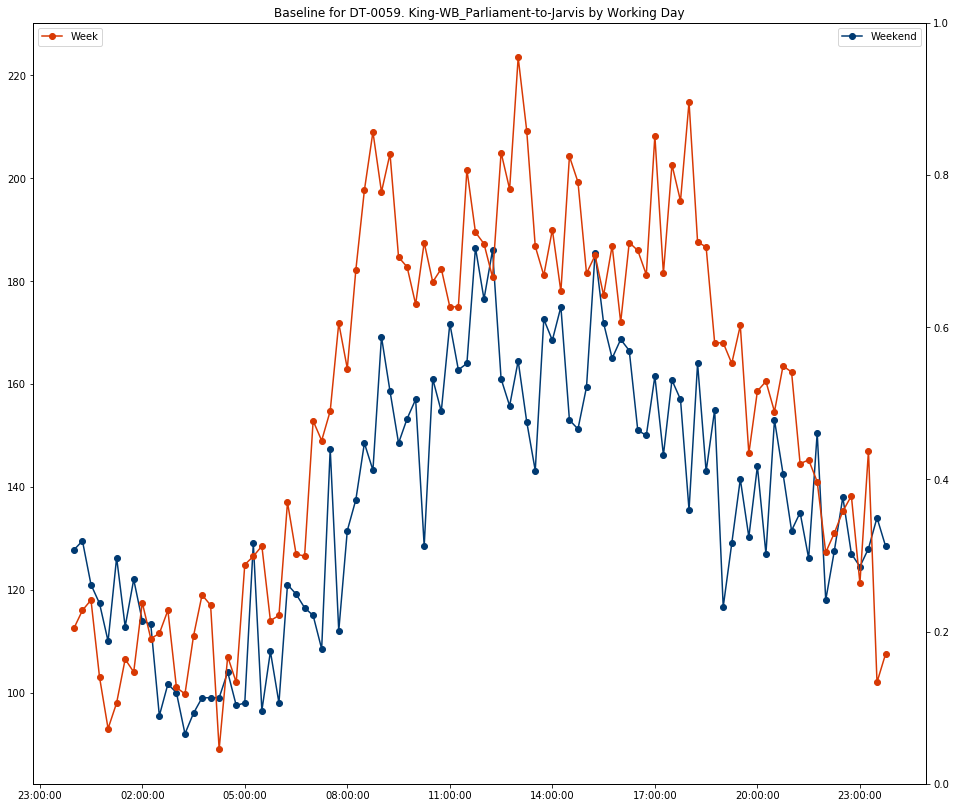

Thirty minute buckets


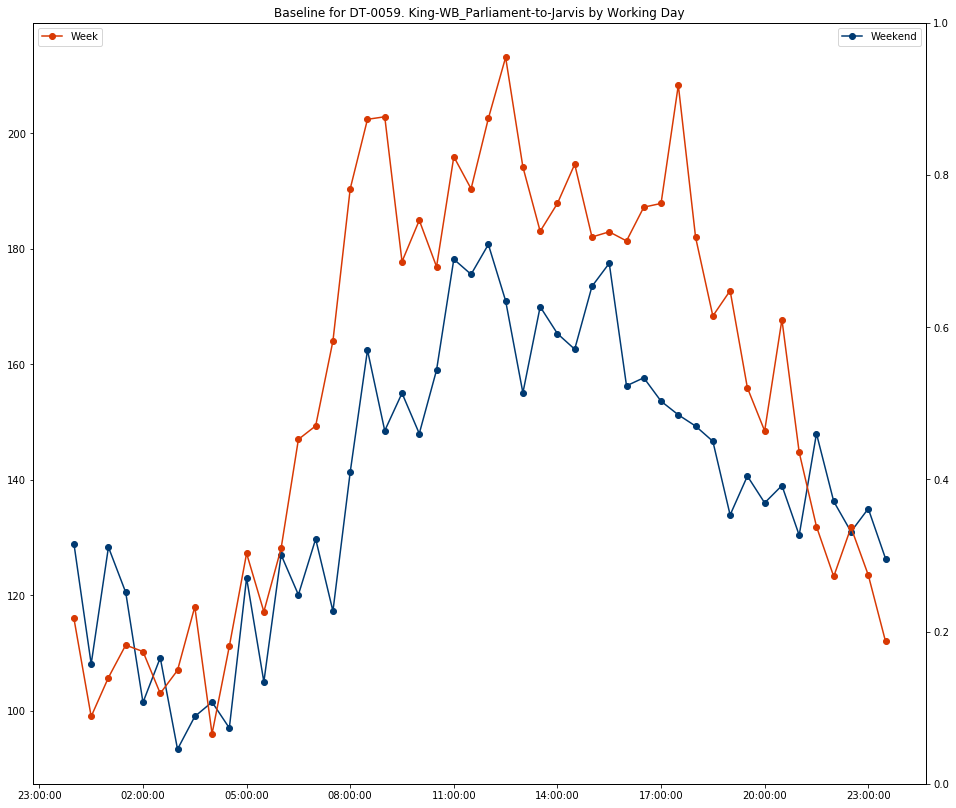

In [6]:
print('Fifteen minute buckets')
plot_base(baselines_15, traveltime_30['report_name'].unique()[58])
print('Thirty minute buckets')
plot_base(baselines_30, traveltime_30['report_name'].unique()[58])

The fifteen minute bucket baseline seems to vary rapidly, making it difficult to interpret. Changing to 30 minute aggregation makes for a much cleaner graph.

### Scatterplots for given (or all) weeks

In [7]:

travelsql_30 = '''
SELECT bt.travel_time, 
    bt.datetime_bin, 
    bt.analysis_id,
    EXTRACT(ISODOW FROM datetime_bin) as weekday,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name
FROM dt_30min_agg bt
    INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)

WHERE hol.dt is NULL
'''
traveltime_30 = pandasql.read_sql(travelsql_30, con)

In [8]:
def WOY(x, W):
    return x.weekofyear == W

def week_dict(r_name):
    weeks = {W : traveltime_30[(traveltime_30['report_name'] == r_name) & 
                 traveltime_30['datetime_bin'].apply(WOY, args = (W,))]
            for W in traveltime_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}
    
    temp = {}
    for week, df in weeks.items():
        if df.travel_time.count() > 0:
            temp[week] = weeks[week]
        else:
            if week in temp: #discard weeks without data to avoid MAXTICKS error
                del temp[week]
    return temp

Creates a dictionary to store the bluetooth observations (30 minute) divided by week and removes empty weeks to keep the graph clean

In [9]:
def plot_weeks(seg_name, *args):
    weeks = week_dict(seg_name) #returns dictionary with seg_name divided into weeks
    
    if len(args) > 0: #if plotting specific weeks, trim weeks to contain said weeks
        temp = {}
        for week in args:
            temp[week] = weeks[week]
        weeks = temp
        
    fig, ax = plt.subplots(len(weeks), 1, sharex = False, sharey = True, figsize = (16, 5*len(weeks)))
    plt.suptitle('Travel times by week for ' + str(seg_name))
    
    if len(args) == 1: #if there's only one week, there's only one subplot, and ax is not iterable. 
        temp = []
        temp.append(ax)
        ax = temp #oh look, ax is iterable.

    for i, week in enumerate(weeks):
            ax[i].plot_date(x = weeks[week].datetime_bin,
                            y = weeks[week].travel_time)

            ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = [0, 1, 2, 3, 4, 5, 6])) #axis setup
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%a %Y-%m-%d'))
            ax[i].xaxis.set_minor_locator(mdates.HourLocator(interval = 3))
            ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
            
            #start = dt - timedelta(days=dt.weekday())
           # end = start + timedelta(days=6)
            ax[i].set_xlim(min(weeks[week].datetime_bin), max(weeks[week].datetime_bin))

            ax[i].set_title(str(week))# titles & labels
            ax[i].set_xlabel('Time')
            ax[i].set_ylabel('Travel Time')
            ax[i].legend()
            ax[i].xaxis.grid(True, which="major")
            ax[i].yaxis.grid(True, which="major")

    fig.tight_layout() #subplot titles bumping into  main title
    
    if len(args) > 0:
        fig.subplots_adjust(top=0.88) # keep titles from getting distracted by their phones and bumping into the axis above.
    else:
        fig.subplots_adjust(top=0.965)
    
    plt.show()

For each segment identified in the baseline lookover, the above function will be used to first plot all weeks, then plot only the weeks with the questionable data, as identified from the first plot.

### Baselines overlaid onto percentile bands query and function

In [10]:
sql = '''SELECT base.daytype,
	('2017-11-12 ' || base.time::varchar)::timestamp as time,
	base.avg_tt as base_tt,
	base.analysis_id,
    max(report_name) as report_name,

	percentile_cont(0.1) WITHIN GROUP (ORDER BY bt.travel_time) as pct_10,
    percentile_cont(0.2) WITHIN GROUP (ORDER BY bt.travel_time) as pct_20,
	percentile_cont(0.4) WITHIN GROUP (ORDER BY bt.travel_time) as pct_40,
    
	percentile_cont(0.6) WITHIN GROUP (ORDER BY bt.travel_time) as pct_60,
	percentile_cont(0.8) WITHIN GROUP (ORDER BY bt.travel_time) as pct_80,
    percentile_cont(0.9) WITHIN GROUP (ORDER BY bt.travel_time) as pct_90,
	percentile_cont(1.0) WITHIN GROUP (ORDER BY bt.travel_time) as pct_100,

	max(translate(right(replace(aa.report_name, ' ', ''), length(replace(aa.report_name, ' ', '')) - 8), '-_', '  ')) as location
	
	
FROM king_pilot_baselines base
	INNER JOIN dt_30min_agg bt ON (bt.analysis_id = base.analysis_id AND bt.datetime_bin::time = base.time AND 
		CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'weekday' ELSE 'weekend' END = base.daytype)
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)

WHERE bt.datetime_bin::date <= '2017-11-12'
	AND bt.datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'

GROUP BY base.analysis_id, base.time, base.daytype, base.avg_tt
'''

travel_times = pandasql.read_sql(sql, con)

In [11]:
travel_times[:5]

daytype                time     base_tt  analysis_id  \
0  weekday 2017-11-12 00:00:00  223.595635      1453138   
1  weekend 2017-11-12 00:00:00  278.669048      1453138   
2  weekday 2017-11-12 00:30:00  216.456944      1453138   
3  weekend 2017-11-12 00:30:00  298.671458      1453138   
4  weekday 2017-11-12 01:00:00  225.577137      1453138   

                                 report_name      pct_10      pct_20  \
0  DT-0001.College-EB_Bathurst-to-University  180.150000  198.937778   
1  DT-0001.College-EB_Bathurst-to-University  231.086667  238.440000   
2  DT-0001.College-EB_Bathurst-to-University  157.000000  179.200000   
3  DT-0001.College-EB_Bathurst-to-University  259.883333  265.983333   
4  DT-0001.College-EB_Bathurst-to-University  179.900000  188.300000   

       pct_40      pct_60      pct_80   pct_90  pct_100  \
0  221.800000  227.700000  241.000000  262.500    346.0   
1  251.895238  263.450000  279.813333  341.080    409.0   
2  201.800000  217.200000  248.800000  274.400    368.0   
3  277.026667  292.591667  332.066667  353.325    411.0   
4  210.590000  228.133333  241.400000  262.800    381.0   

                            location  
0  College EB Bathurst to University  
1  College EB Bathurst to University  
2  College EB Bathurst to University  
3  College EB Bathurst to University  
4  College EB Bathurst to University

In [12]:
def plot_base(observations, r_name):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'week' : observations[(observations['report_name'] == r_name) & 
                         (observations['daytype'] == 'weekday')].sort_values(['time']),
                'weekend' : observations[(observations['report_name'] == r_name) & 
                         (observations['daytype'] == 'weekend')].sort_values(['time'])}
        
    fig, daytype = plt.subplots(2, 1, figsize = (16,14))
    outliers = []
    
    for i, (color, WD) in enumerate(zip(colors, ['weekend', 'week'])):        
        
        daytype[i].set_title('Baseline for ' + max(segments['week'].location) + ' during the ' + str(WD))
        daytype[i].plot_date(x = segments[WD].time,
                          y = segments[WD].base_tt,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
        
        daytype[i].fill_between(segments[WD].time.values, 
                            y1=segments[WD]['pct_10'],
                            y2=segments[WD]['pct_90'],
                            alpha=0.15, facecolor=color)
        daytype[i].fill_between(segments[WD].time.values, 
                            y1=segments[WD]['pct_20'],
                            y2=segments[WD]['pct_80'],
                            alpha=0.25, facecolor=color)
        daytype[i].fill_between(x = segments[WD].time.values, 
                            y1=segments[WD]['pct_40'],
                            y2=segments[WD]['pct_60'],
                            alpha=0.35, facecolor=color)
               
        daytype[i].set_xlim(min(segments[WD].time), max(segments[WD].time))
        daytype[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 3))
        daytype[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        
        daytype[i].xaxis.set_label_text('Time')
        daytype[i].yaxis.set_label_text('Travel Time')
        
        daytype[i].yaxis.grid(True)
        daytype[i].xaxis.grid(True)
        
        outliers.append(daytype[i].twiny())
        
        outliers[i].plot_date(x = segments[WD]['time'],
                              y = segments[WD]['pct_100'],
                              fmt = 'o',
                              xdate = True)
        
        outliers[i].xaxis.set_visible(False)
        outliers[i].set_xlim(min(segments[WD].time), max(segments[WD].time))
    
    daytype[0].legend()
    daytype[1].legend(loc = 'upper left')
    
    plt.show()

### Plot baseline with prospective outliers removed against old baseline

In [13]:
def daystring(cut_days):
    cut_day_str = '(\'' + cut_days[0]
    for day in cut_days[1:]:
        cut_day_str = cut_day_str + '\', \'' + day
    return cut_day_str + '\')'

In [14]:
new_sql = '''WITH bt as (
    SELECT bt.analysis_id,
	aa.report_name,
	(TIMESTAMP WITHOUT TIME ZONE 'epoch' + INTERVAL '1 second' * (floor((extract('epoch' from bt.datetime_bin)-1) / 1800) * 1800)) as datetime_bin,
	sum(bt.tt*bt.obs)/sum(bt.obs) AS travel_time,
 	sum(bt.obs) AS obs

    FROM bluetooth.aggr_5min bt
	INNER JOIN bluetooth.all_analyses aa USING (analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::date = hol.dt)
        
    WHERE bt.datetime_bin::date  NOT IN {0} AND
         datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
        AND hol.dt is NULL
        AND aa.report_name = '{1}'

   GROUP BY datetime_bin, analysis_id, aa.report_name)

SELECT '2017-11-12'::date + datetime_bin::time as time, 
    avg(bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin::date) < 6 THEN 'weekday' ELSE 'weekend' END as daytype,
    report_name

FROM  bt

GROUP BY report_name, 
    datetime_bin::time, 
    daytype'''


old_sql = '''WITH bt as(
    SELECT bt.analysis_id,
	aa.report_name,
	(TIMESTAMP WITHOUT TIME ZONE 'epoch' + INTERVAL '1 second' * (floor((extract('epoch' from bt.datetime_bin)-1) / 1800) * 1800)) as datetime_bin,
	sum(bt.tt*bt.obs)/sum(bt.obs) AS travel_time,
 	sum(bt.obs) AS obs

    FROM bluetooth.aggr_5min bt
	INNER JOIN bluetooth.all_analyses aa USING (analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    WHERE datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
        AND hol.dt is NULL
        AND aa.report_name = '{0}'

   GROUP BY datetime_bin, analysis_id, aa.report_name
)
SELECT '2017-11-12'::date + datetime_bin::time as time, 
    avg(bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'weekday' ELSE 'weekend' END as daytype,
    report_name

FROM  bt

GROUP BY report_name, 
    datetime_bin::time, 
    daytype'''

The baseline query from above, modified to exclude anomalistic dates.

In [15]:
def alternate_baseline(r_name, cut_day_str):
    
    new_base = pandasql.read_sql(new_sql.format(daystring(cut_day_str), r_name), con)
    old_base = pandasql.read_sql(old_sql.format(r_name), con)
    
    fig, days = plt.subplots(2, 1, figsize = (16,16))
    old = []

    segments = {order : {'Work' : observations[(observations['report_name'] == r_name) & 
                                               (observations['daytype'] == 'weekday')].sort_values(['time']),
                         'Weekend' : observations[(observations['report_name'] == r_name) & 
                                                    (observations['daytype'] == 'weekend')].sort_values(['time'])}
                for order, observations in zip(['New', 'Old'],[new_base, old_base])}


    for i, WD in enumerate(['Work', 'Weekend']):
        old.append(days[i].twiny())
        days[i].plot_date(x = segments['New'][WD].time,
                          y = segments['New'][WD].travel_time,
                          xdate = True,
                          fmt = '-o',
                          c = colors[0],
                          alpha = 0.5,
                          label = 'New Baseline')
        plt.legend()
        old[i].plot_date(x = segments['Old'][WD].time,
                         y = segments['Old'][WD].travel_time,
                         xdate = True,
                         fmt = '-o',
                         c = colors[1],
                         alpha = 0.5,
                         label = 'Old Baseline')

        maj = mdates.HourLocator(interval = 3)
        days[i].xaxis.set_major_locator(maj)
        days[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

        #old[i].set_yticks(np.linspace(days[i].get_yticks()[0],days[i].get_yticks()[-1],len(days[i].get_yticks())))
        old[i].get_xaxis().set_visible(False)
        #old[i].get_yaxis().set_visible(True)

        #old[i].get_yaxis().set_visible(False)


        plt.title(str(WD) + ' Baseline for ' + r_name)

        days[i].xaxis.set_label_text('Time')
        days[i].yaxis.set_label_text('Travel Time')

        days[i].legend()
        old[i].legend(loc = 'upper left')

        fig.tight_layout()

    plt.show()

##### The function plotting baselines returns both a weekend (blue) and weekday (orange) plot. Becasue of this not all baseline plots will be anomalistic.

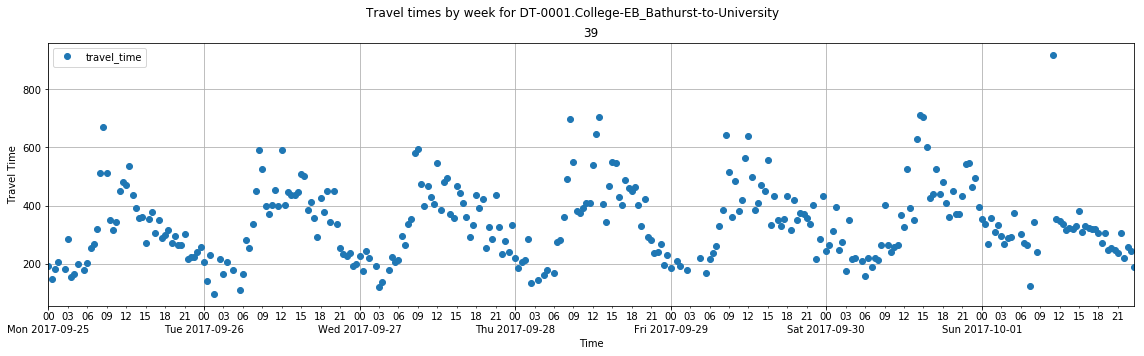

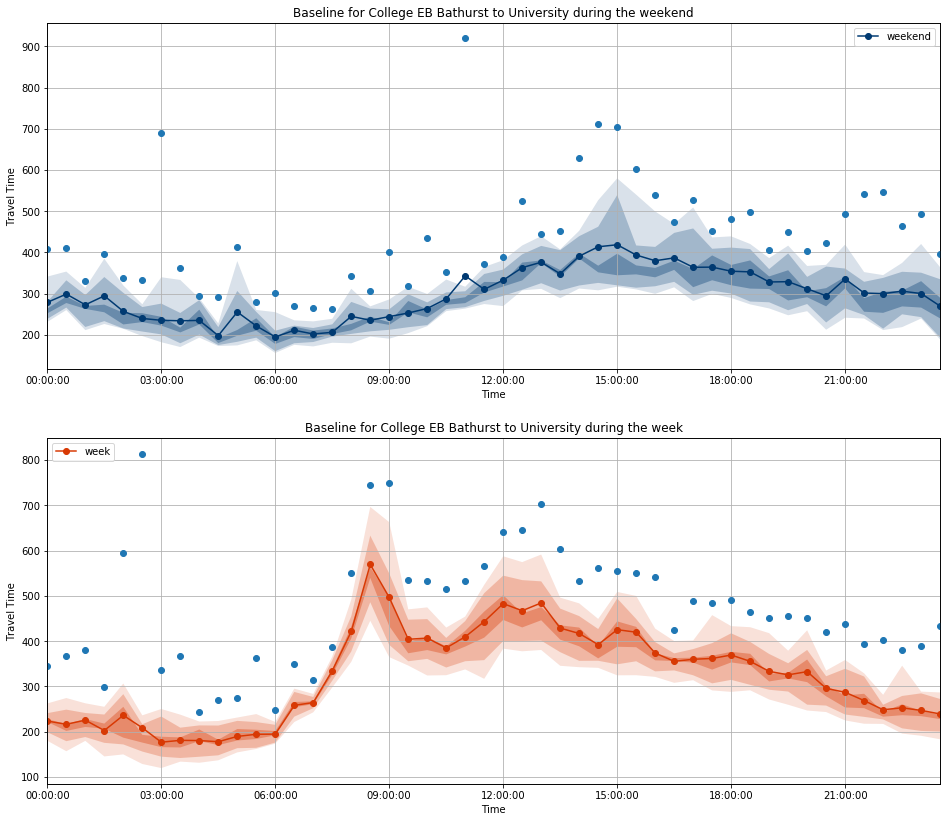

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


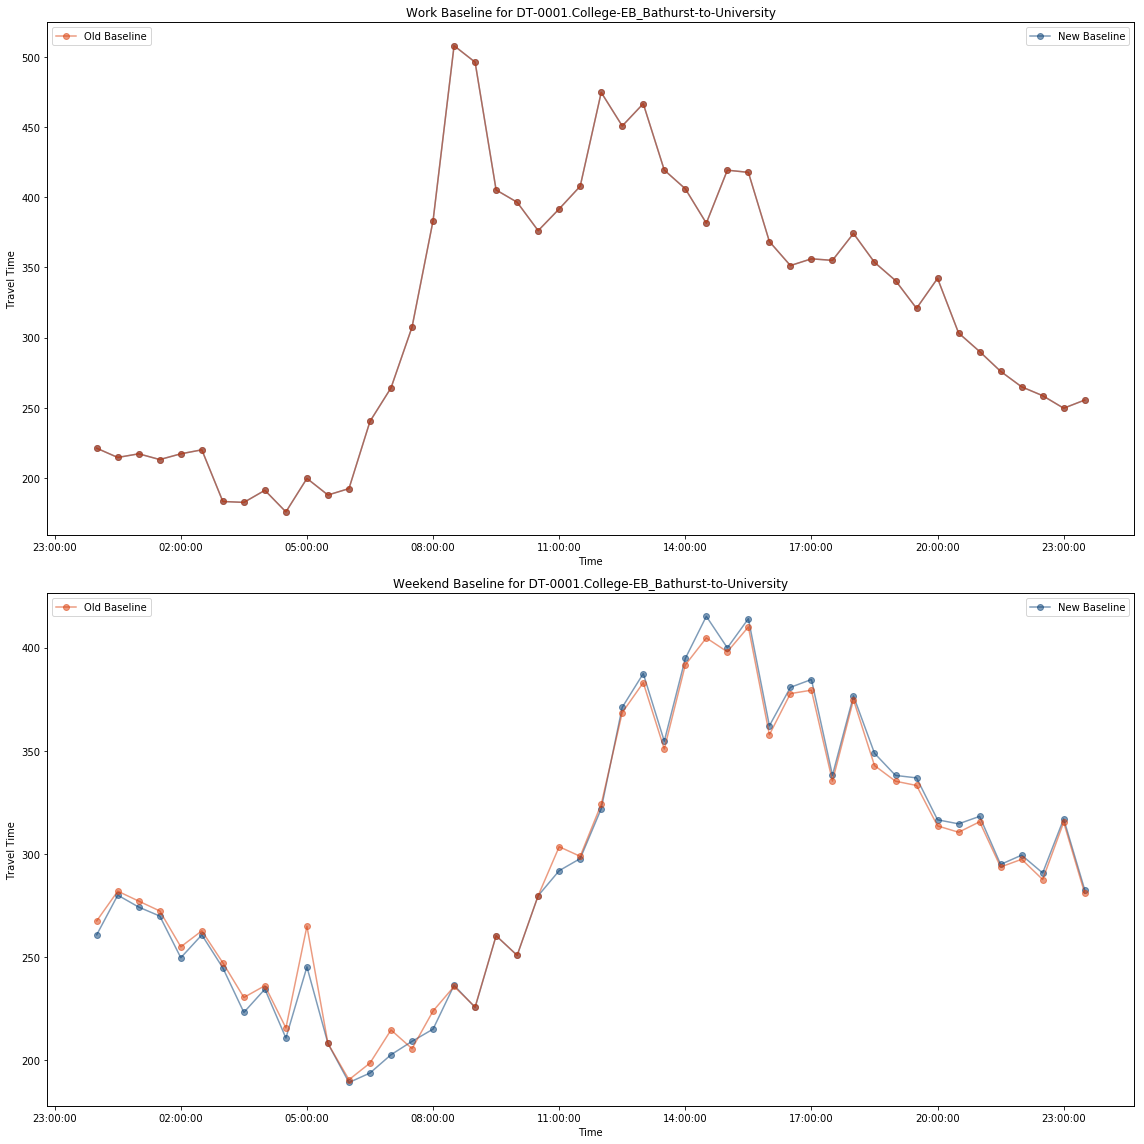

In [16]:
r_name = "DT-0001.College-EB_Bathurst-to-University"
plot_weeks(r_name, 39)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-01'])

Removing October 1st has an insignificant effect on the weekend baseline.

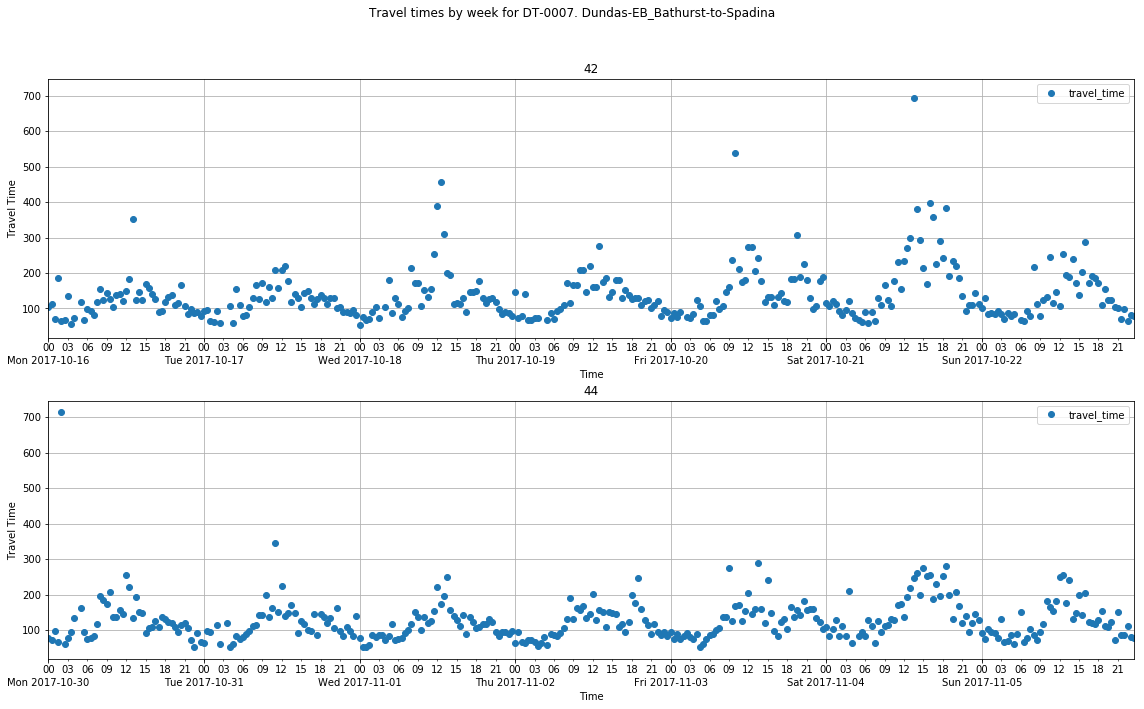

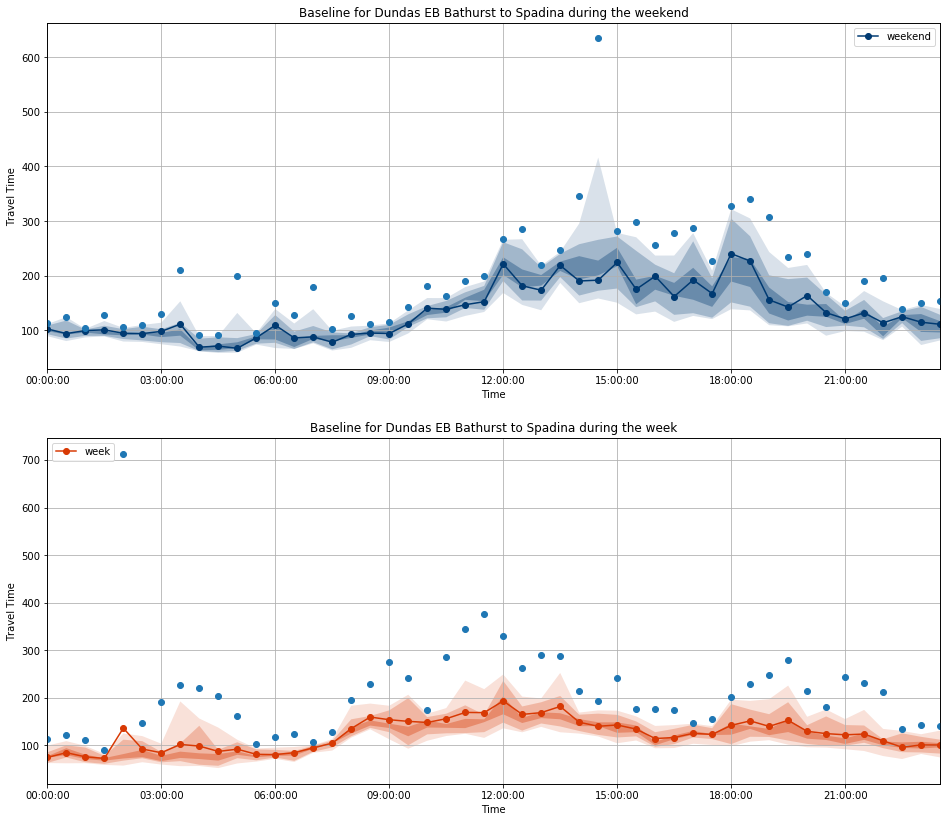

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


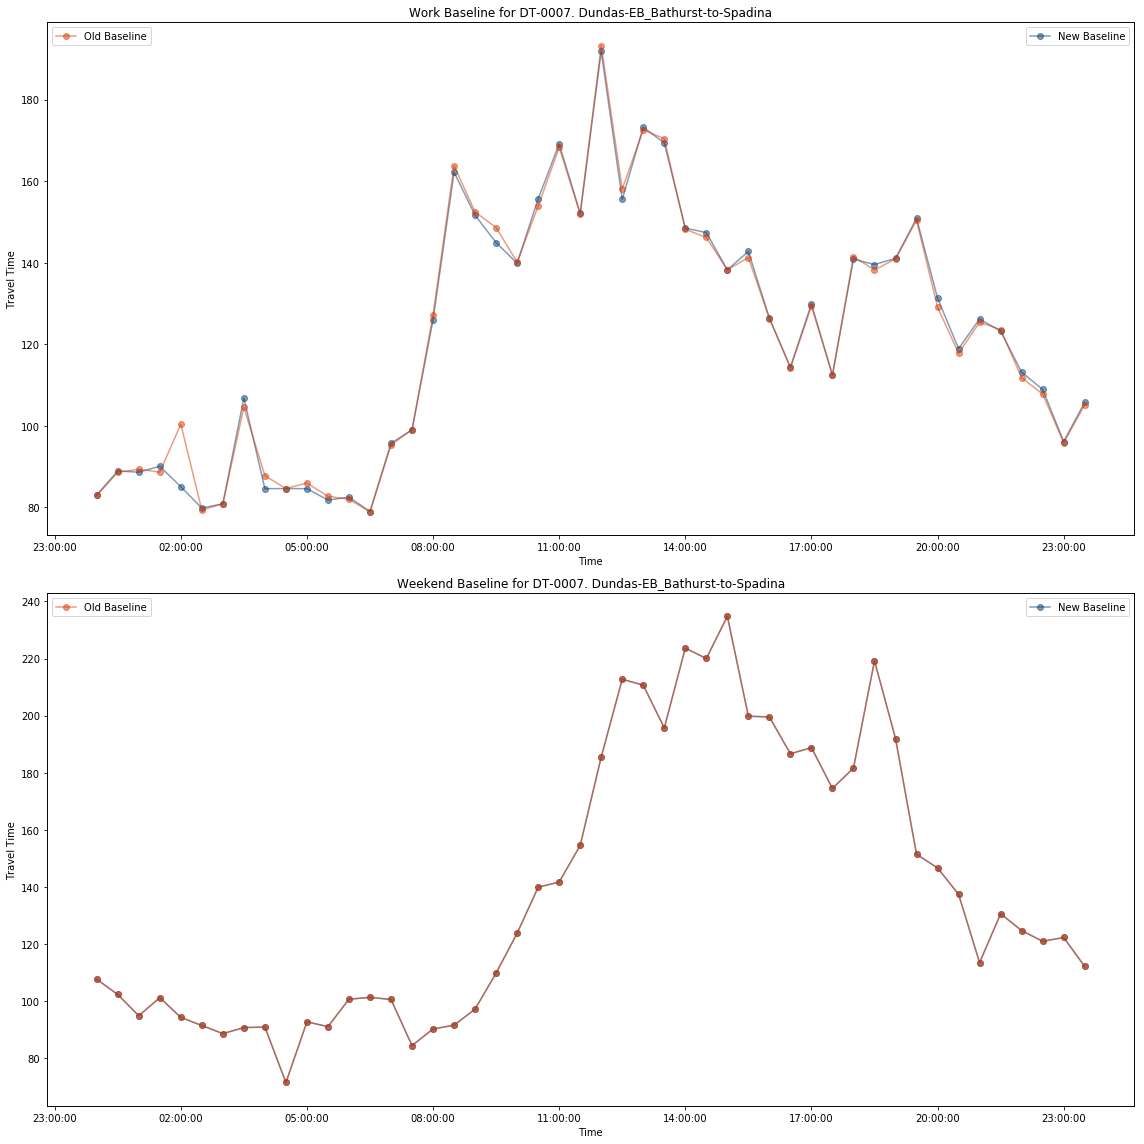

In [17]:
r_name ="DT-0007. Dundas-EB_Bathurst-to-Spadina"
plot_weeks(r_name, 42, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-30'])

Removing October 30th has a minor effect in the early morning during the week.

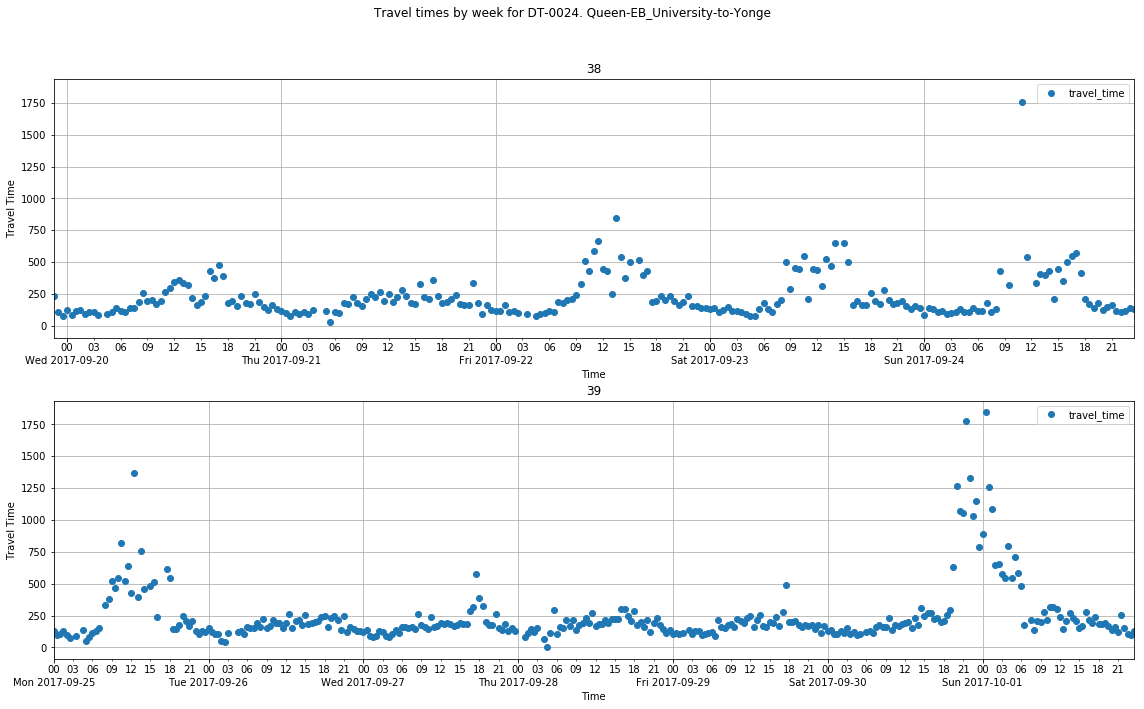

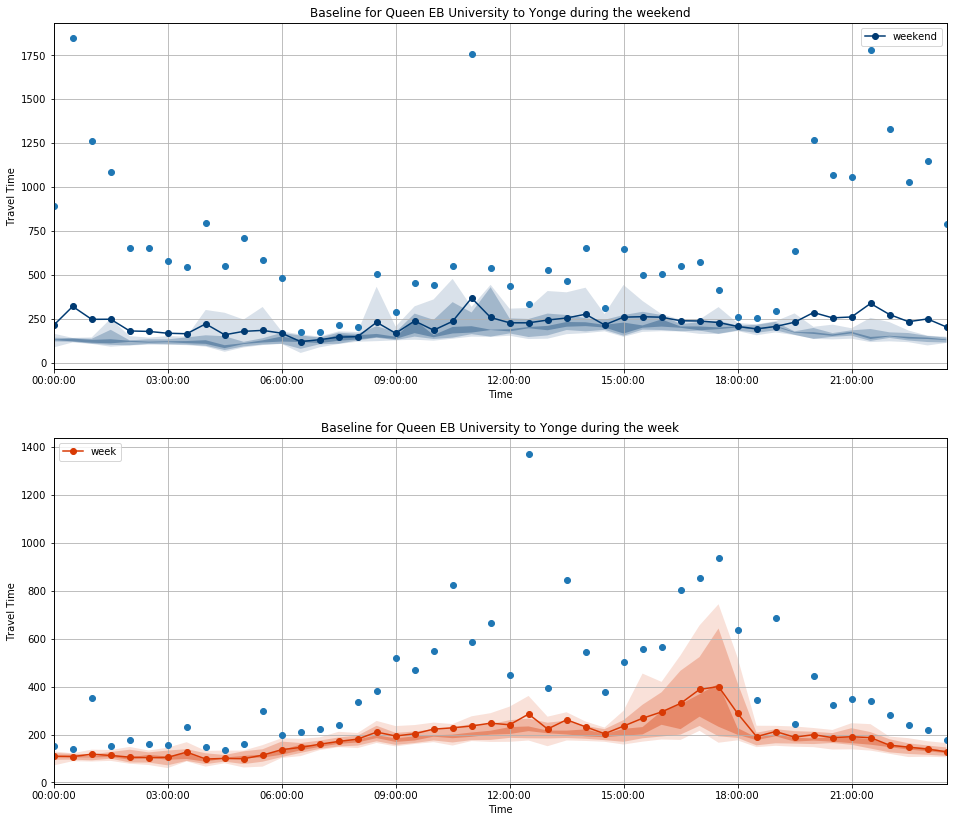

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


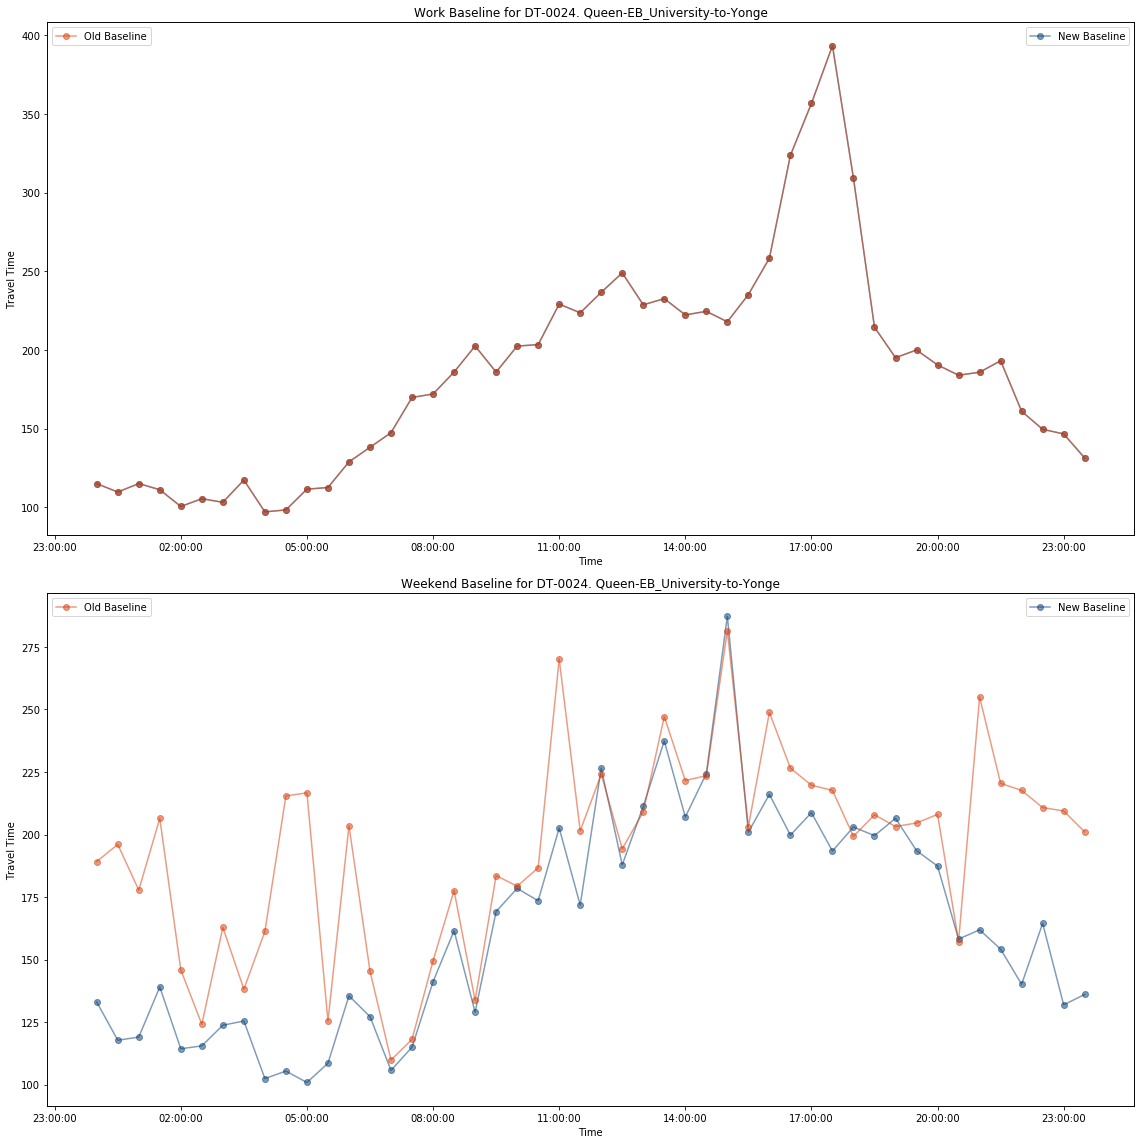

In [18]:
r_name = "DT-0024. Queen-EB_University-to-Yonge"
plot_weeks(r_name, 38, 39)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-24', '2017-09-30', '2017-10-01'])

Removing September 24th, 30th, and October 1st appears to have had a very major impact on this baseline around midnight and during midday on the weekend. Nuit Blanche had a huge impact on this baseline.

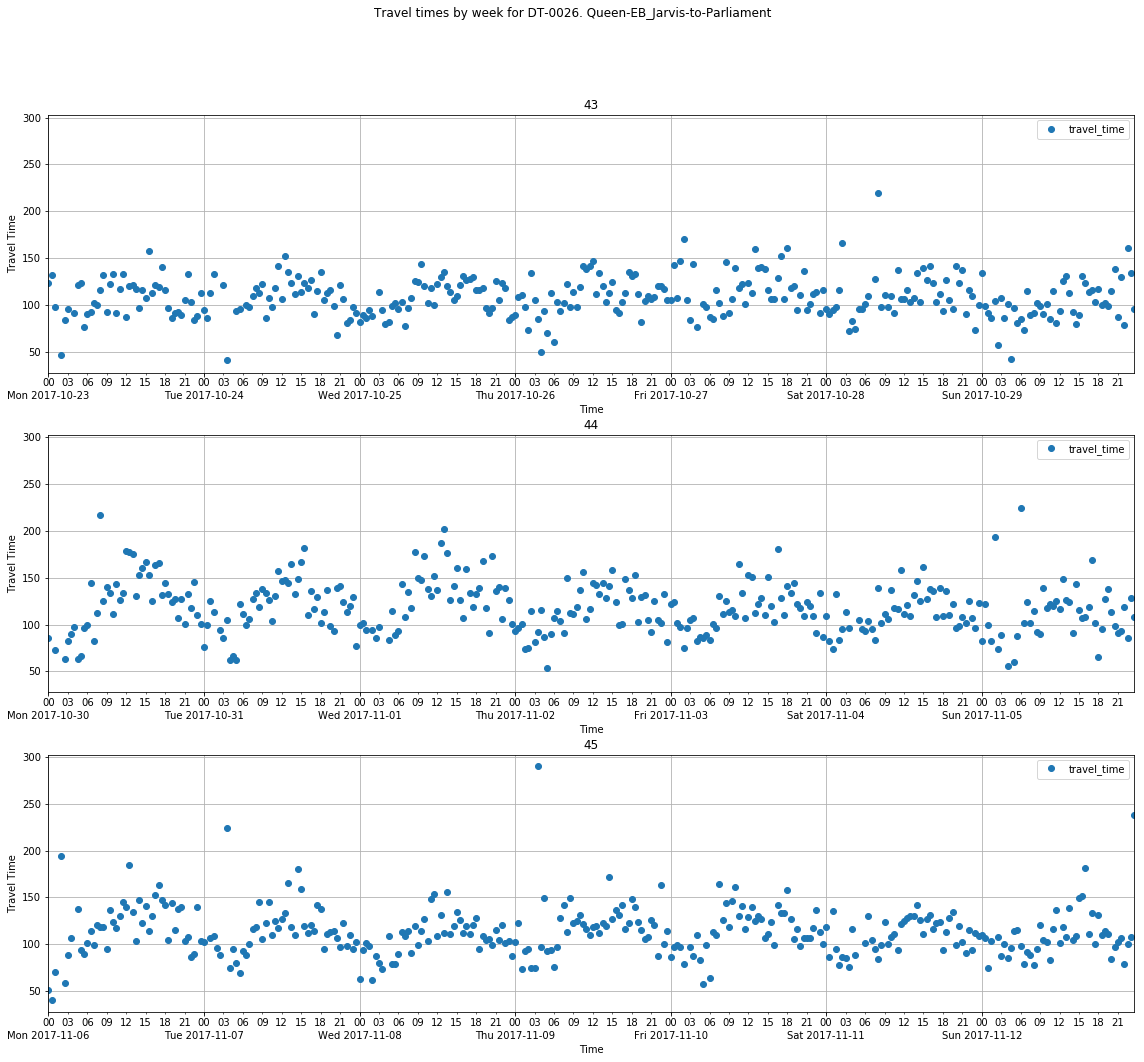

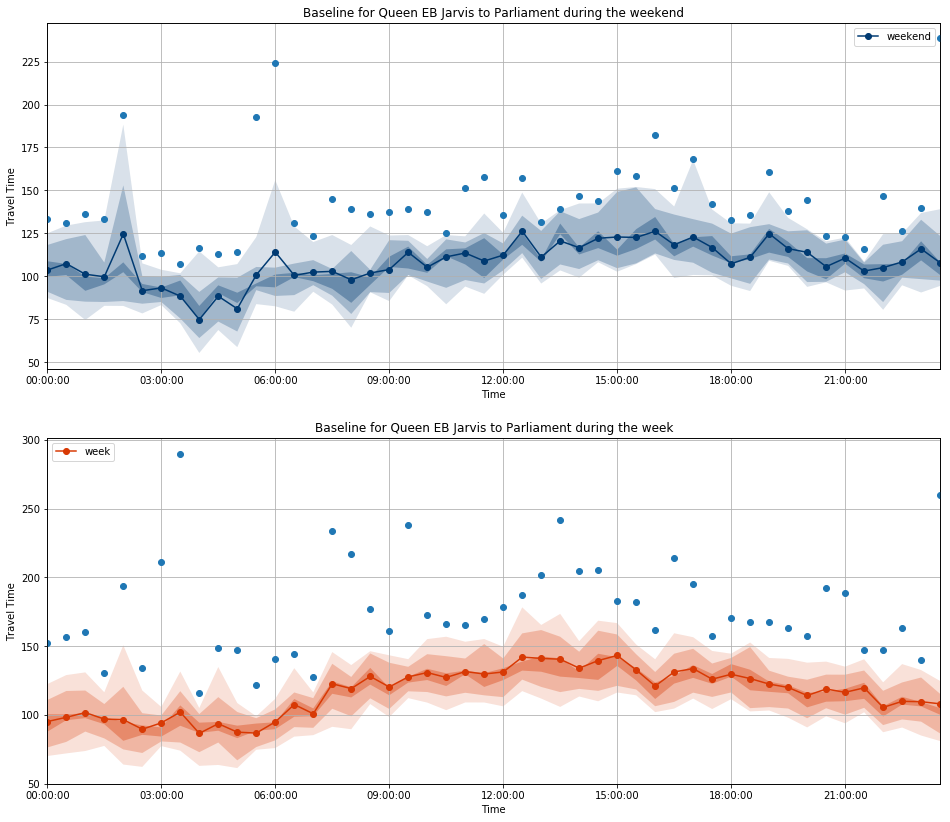

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


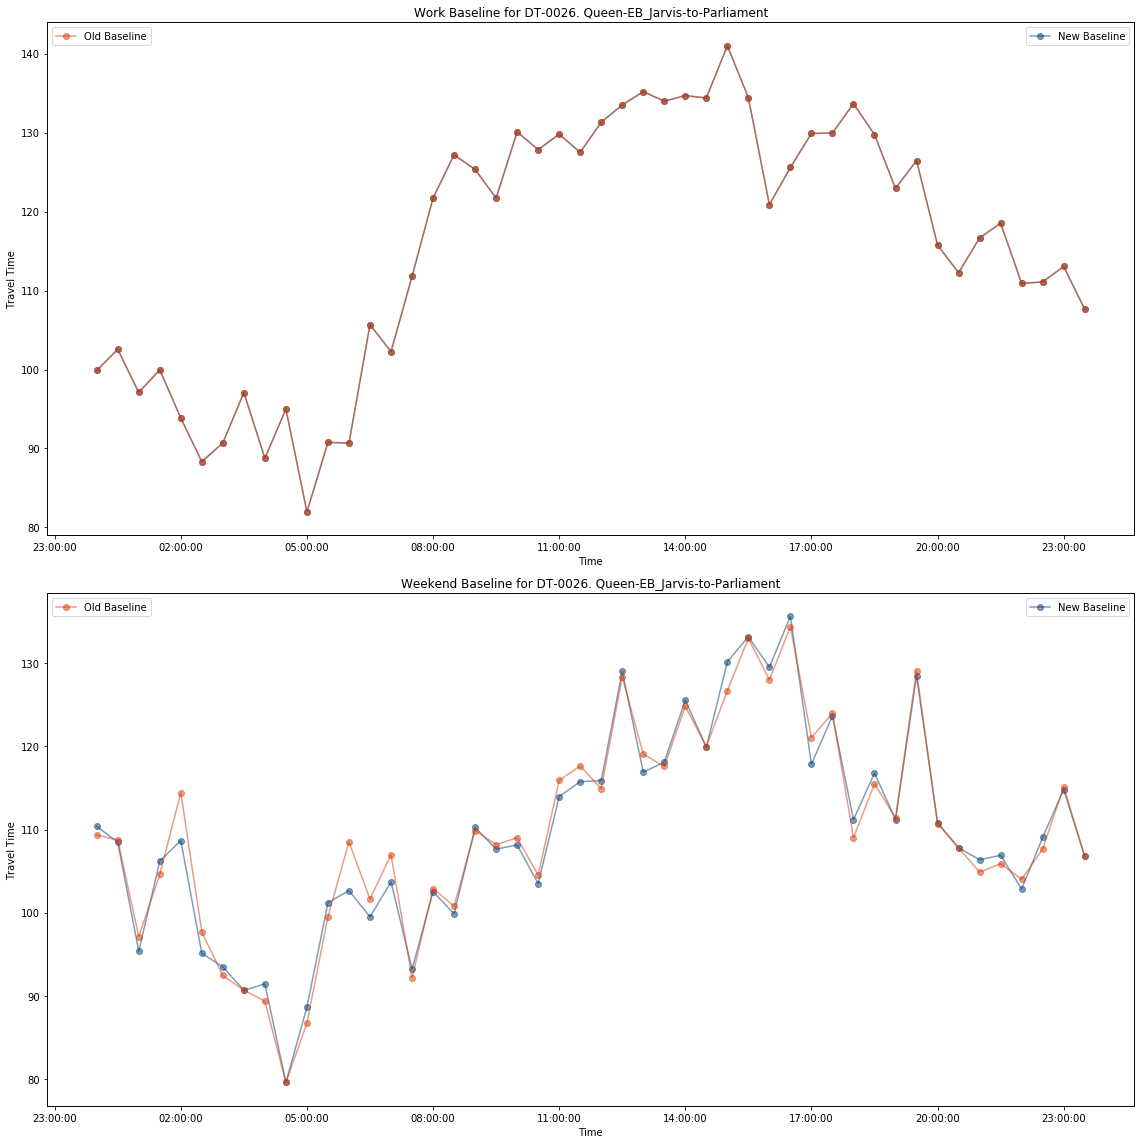

In [19]:
r_name = 'DT-0026. Queen-EB_Jarvis-to-Parliament'
plot_weeks(r_name, 43, 44, 45)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-11-05'])

removing November 5th from this baseline had an insignificant impact on the new baseline.

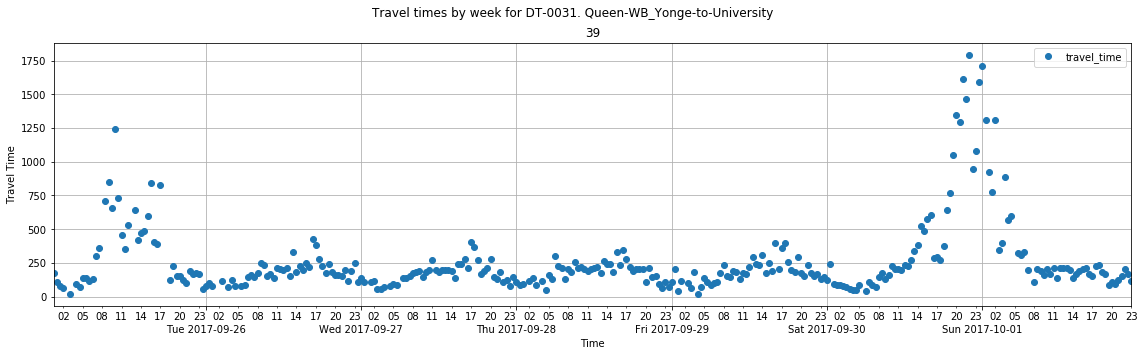

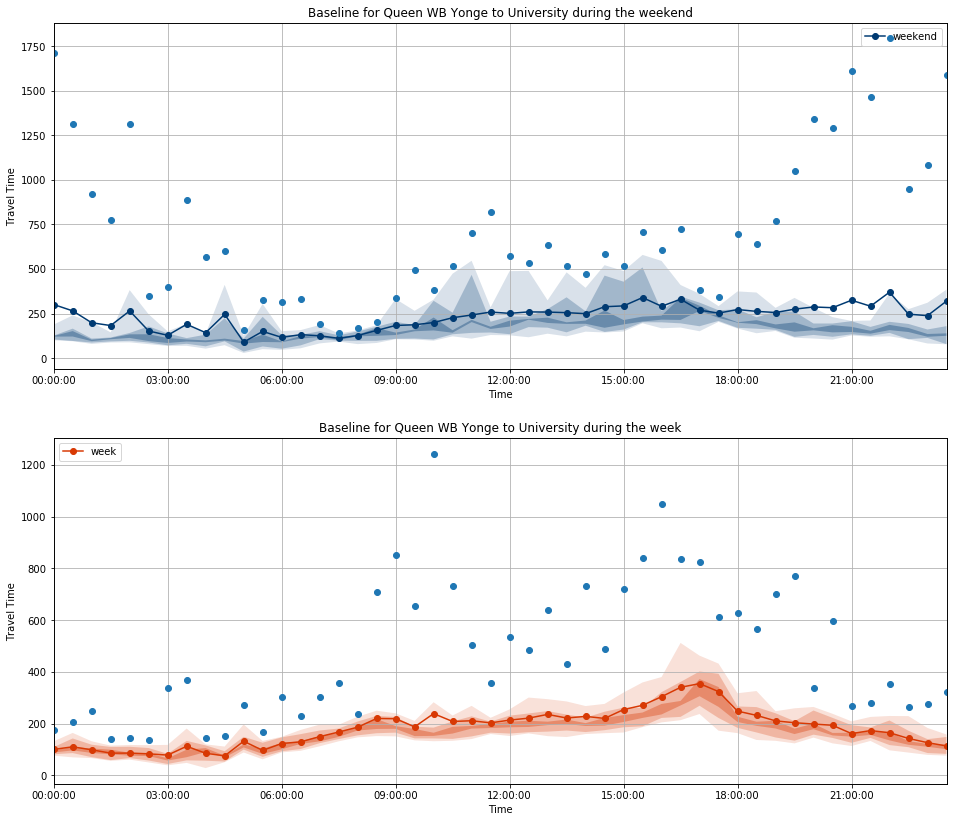

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


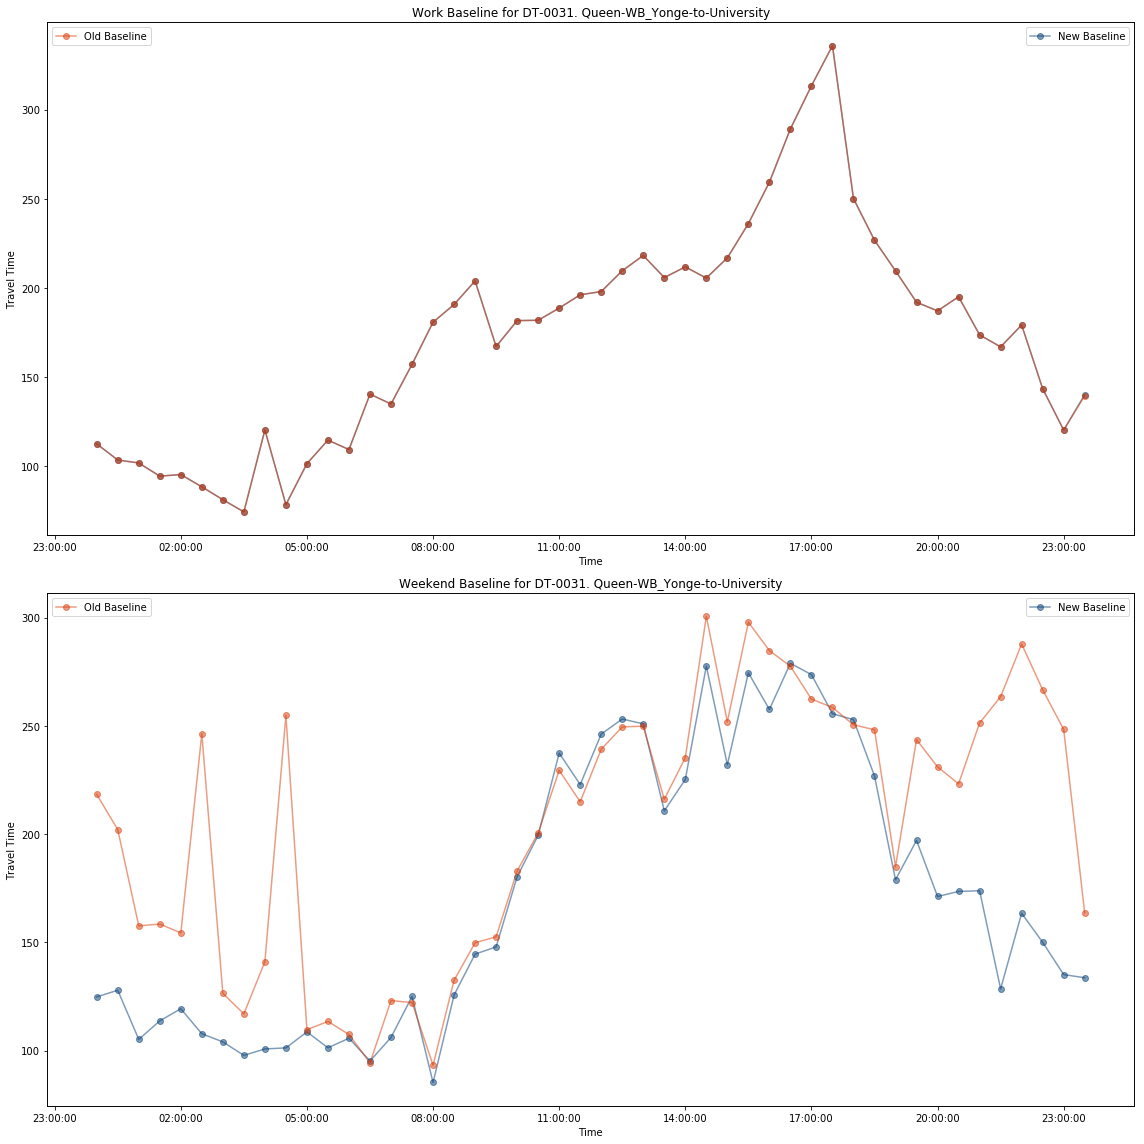

In [20]:
r_name = "DT-0031. Queen-WB_Yonge-to-University"
plot_weeks(r_name, 39)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-30', '2017-10-01'])

Removing September 30th and October 1st had a very major impact on this baseline around midnight on the weekend, due to Nuit Blanche.

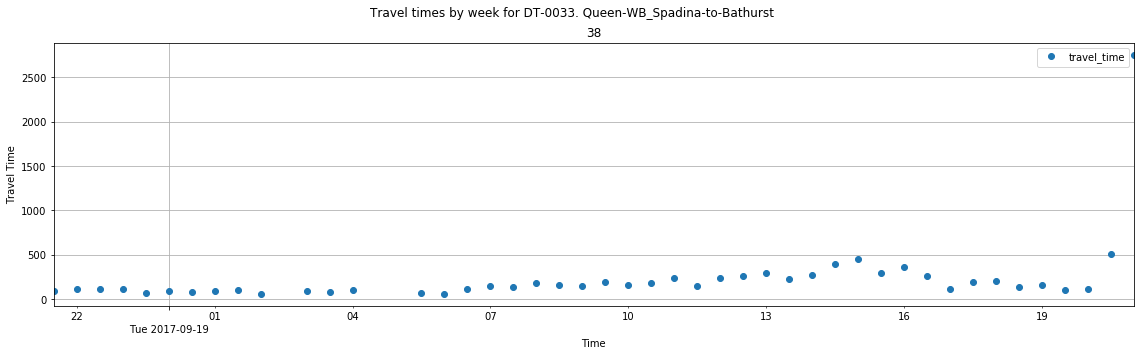

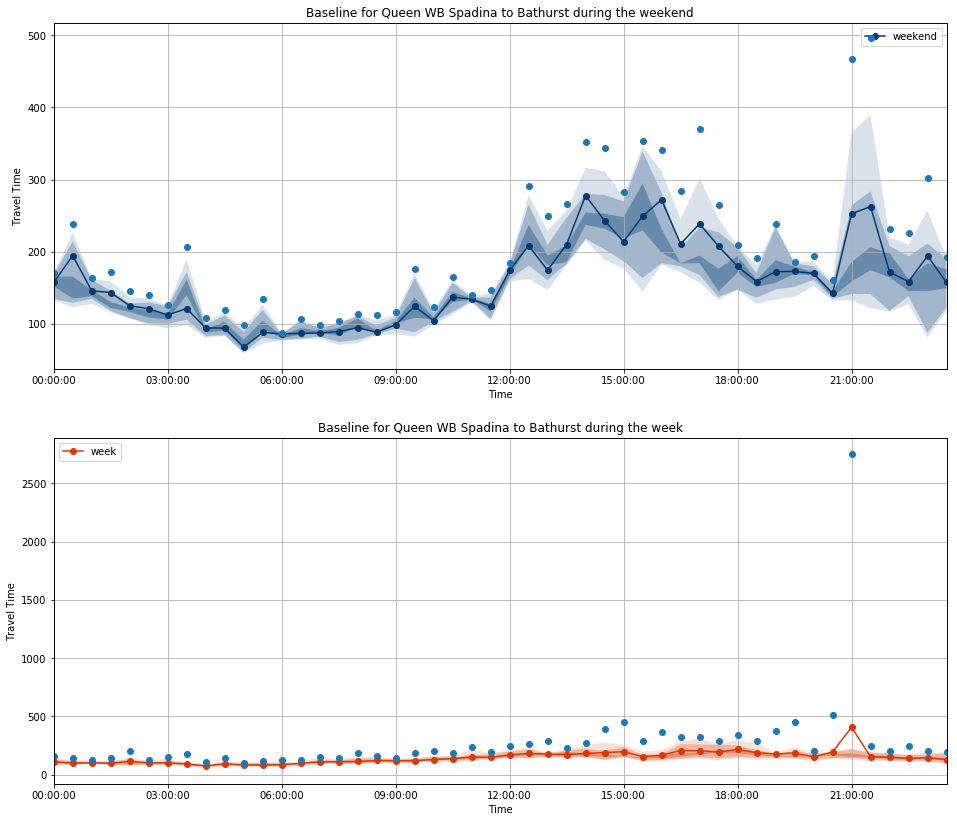

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


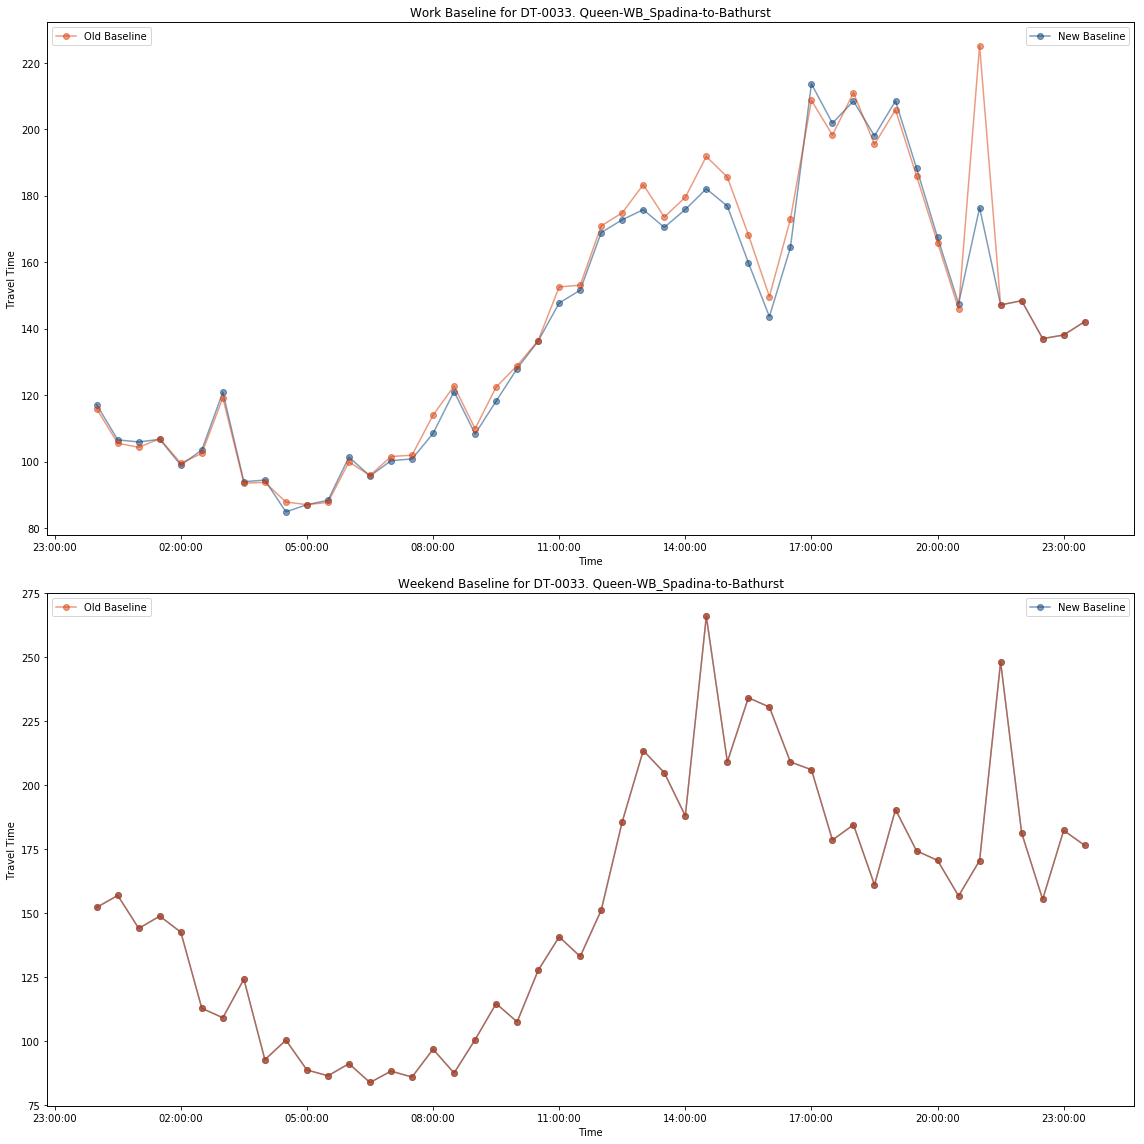

In [21]:
r_name = "DT-0033. Queen-WB_Spadina-to-Bathurst"
plot_weeks(r_name, 38)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-19'])

Excluding September 19th had a significant impact on the late evening baseline during the week. 

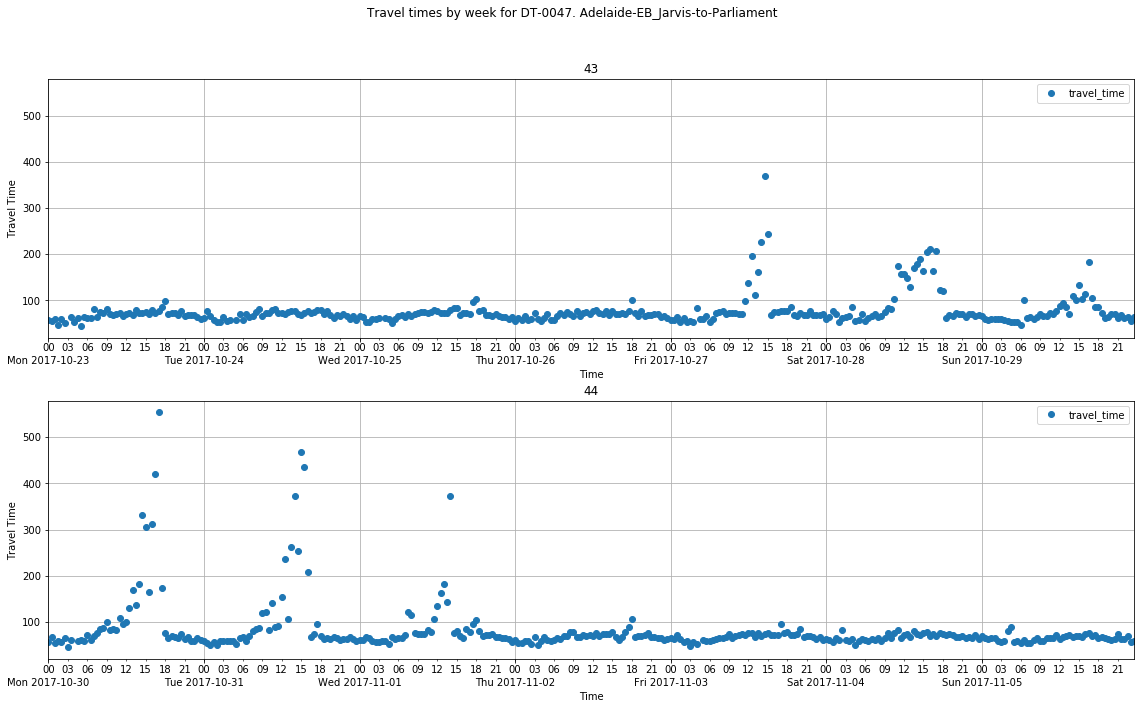

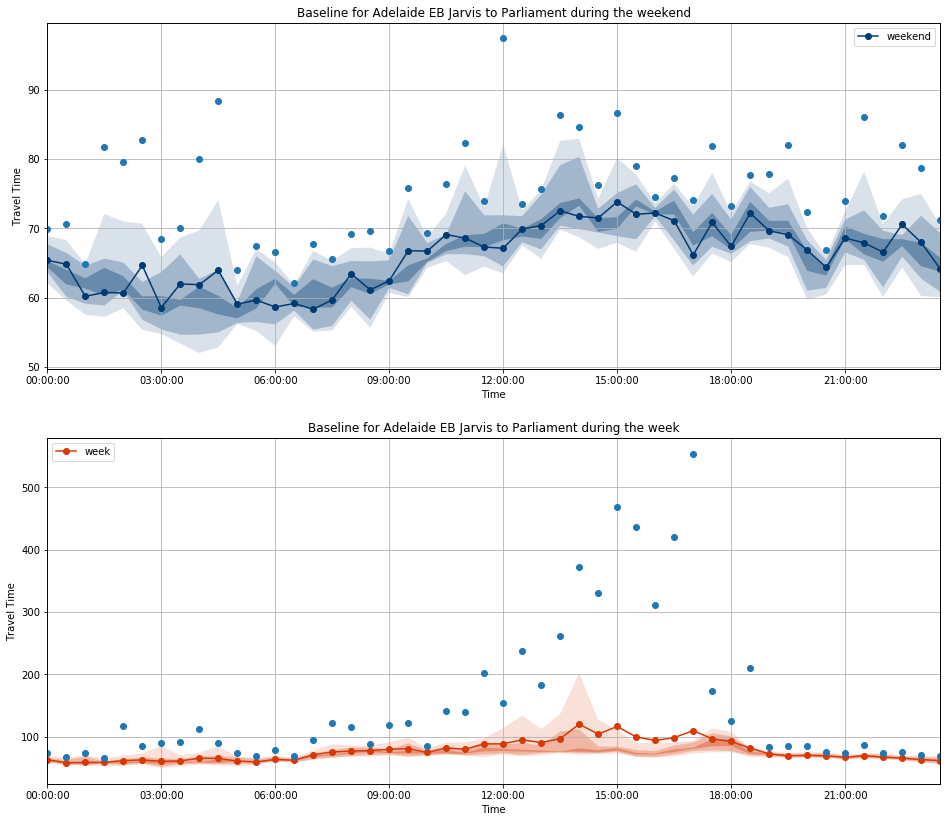

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


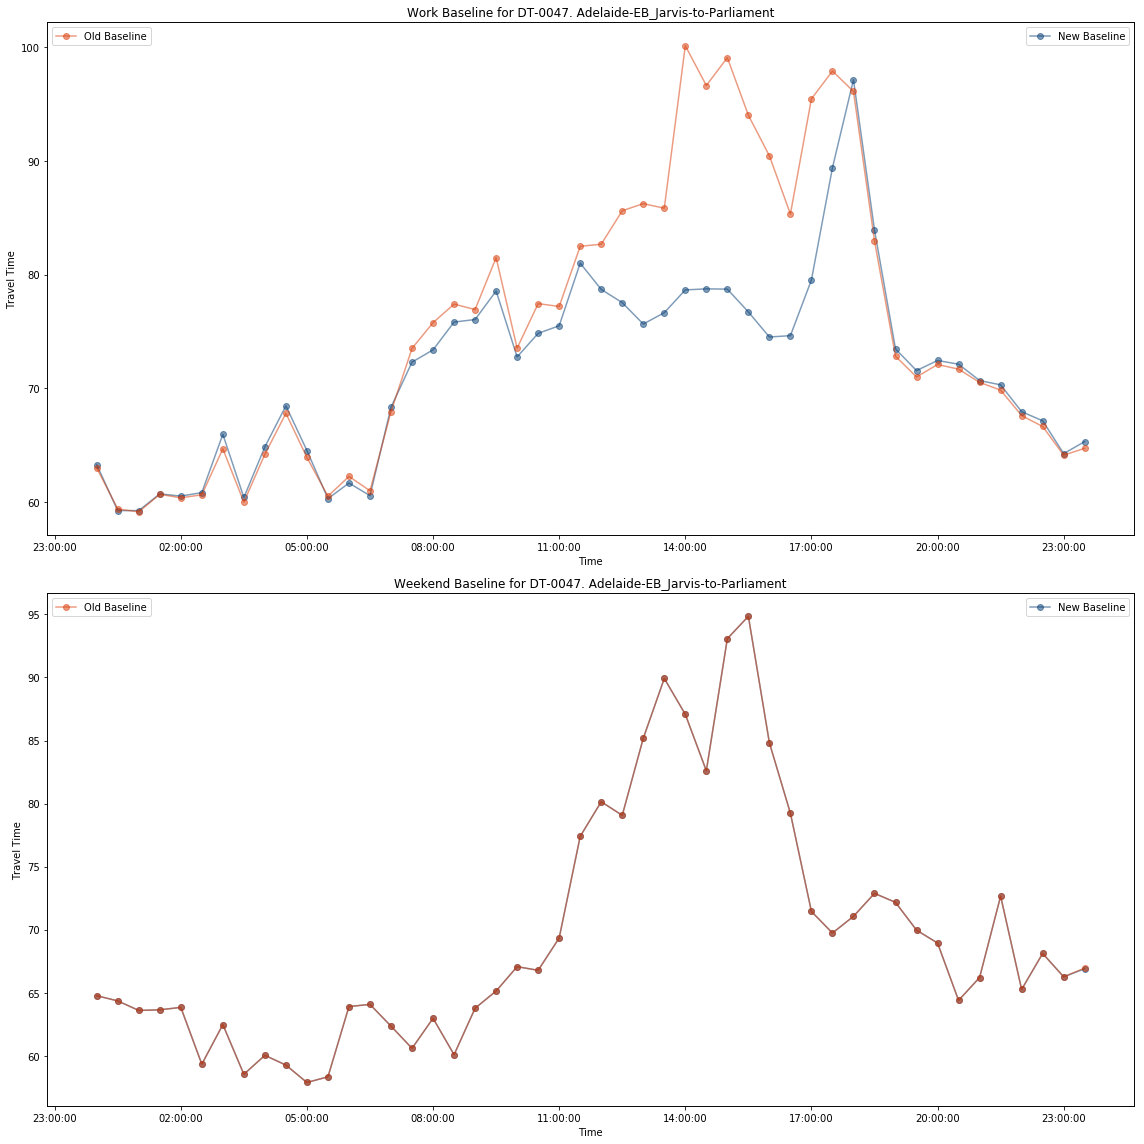

In [22]:
r_name = "DT-0047. Adelaide-EB_Jarvis-to-Parliament"
plot_weeks(r_name, 43, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-30', '2017-10-31', '2017-11-01'])

October 30th, 31st, and November 1st had unique slowdowns significantly larger than any others on this segment. Removing these dates lead to a very major drop in the week baseline around the PM peak.

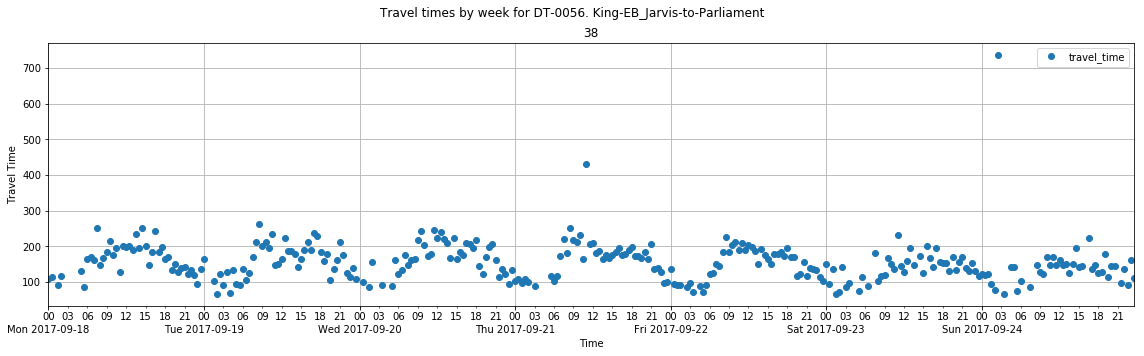

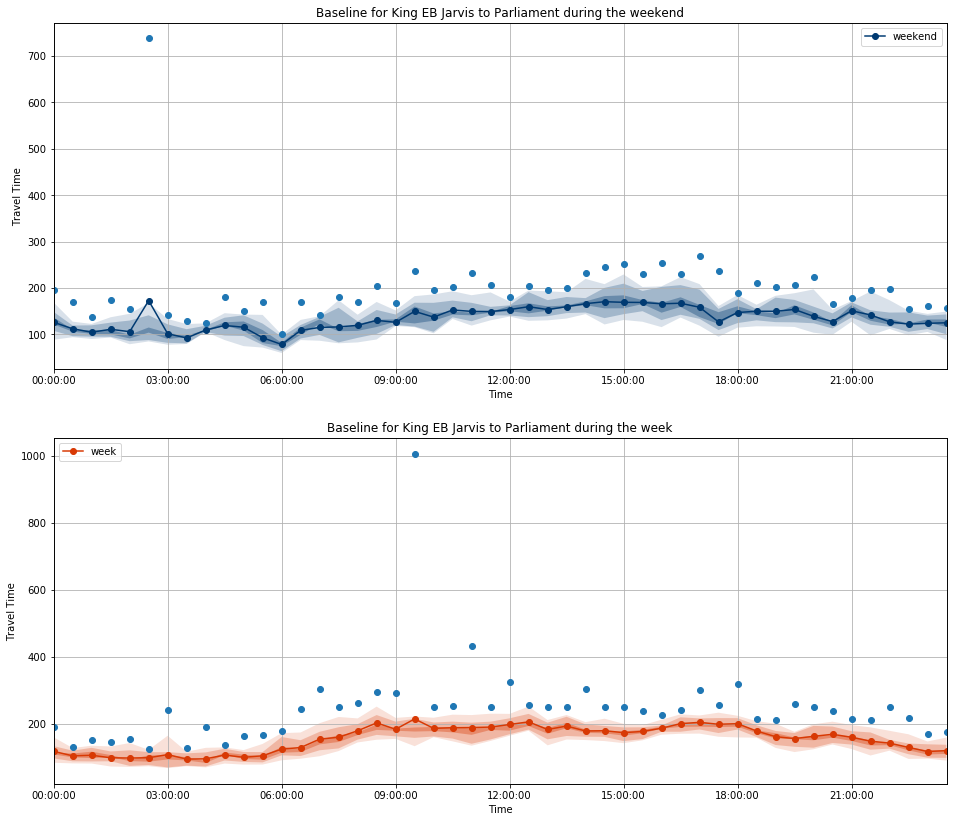

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


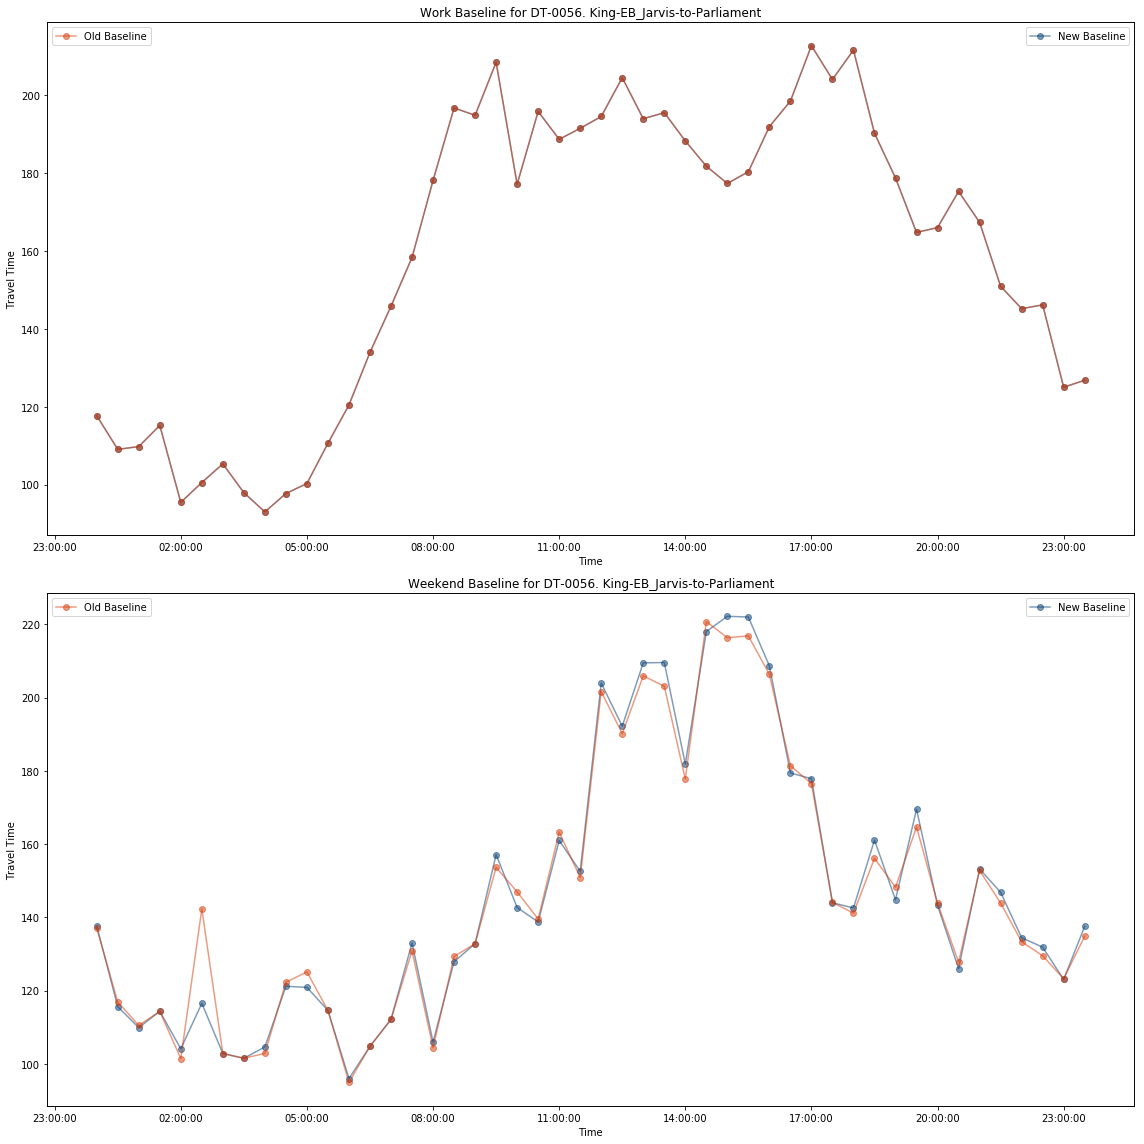

In [23]:
r_name = "DT-0056. King-EB_Jarvis-to-Parliament"
plot_weeks(r_name, 38)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-24'])

Removing september 24th had a noticable impact on the weekend baseline in the early morning.

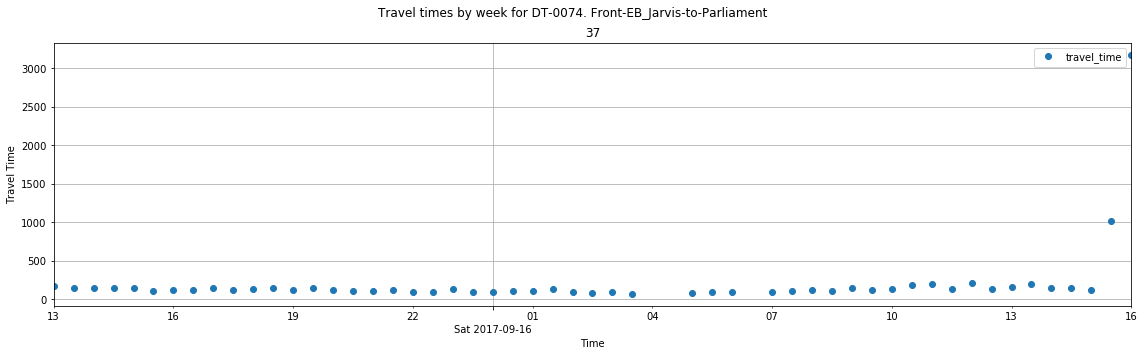

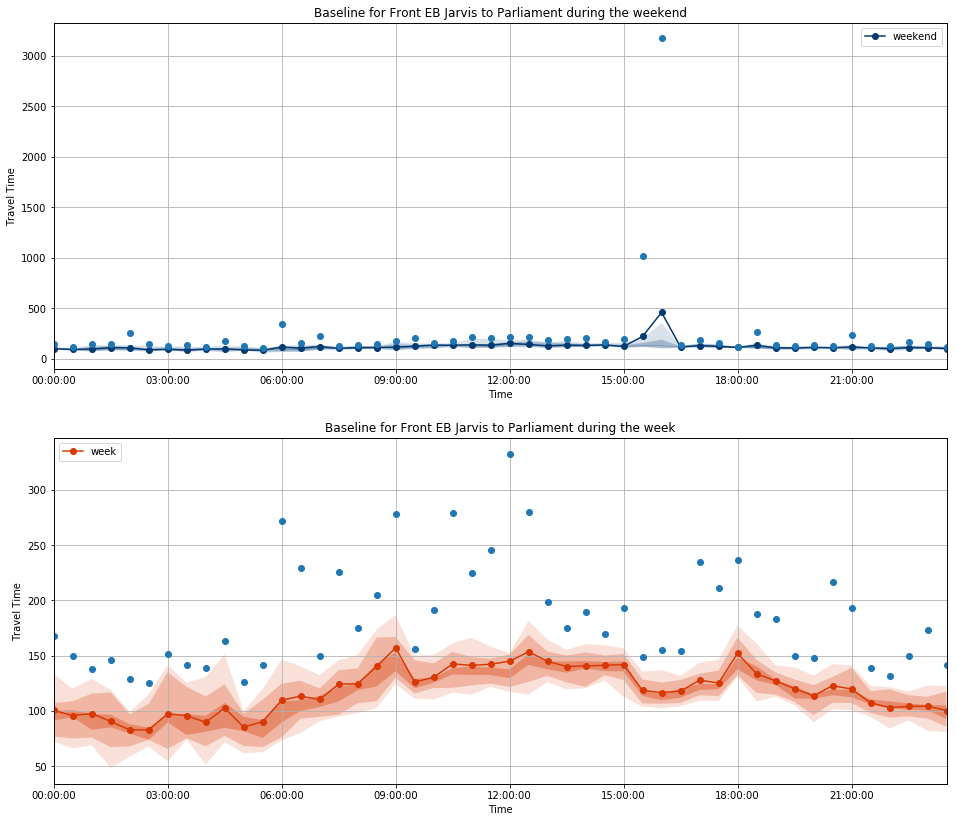

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


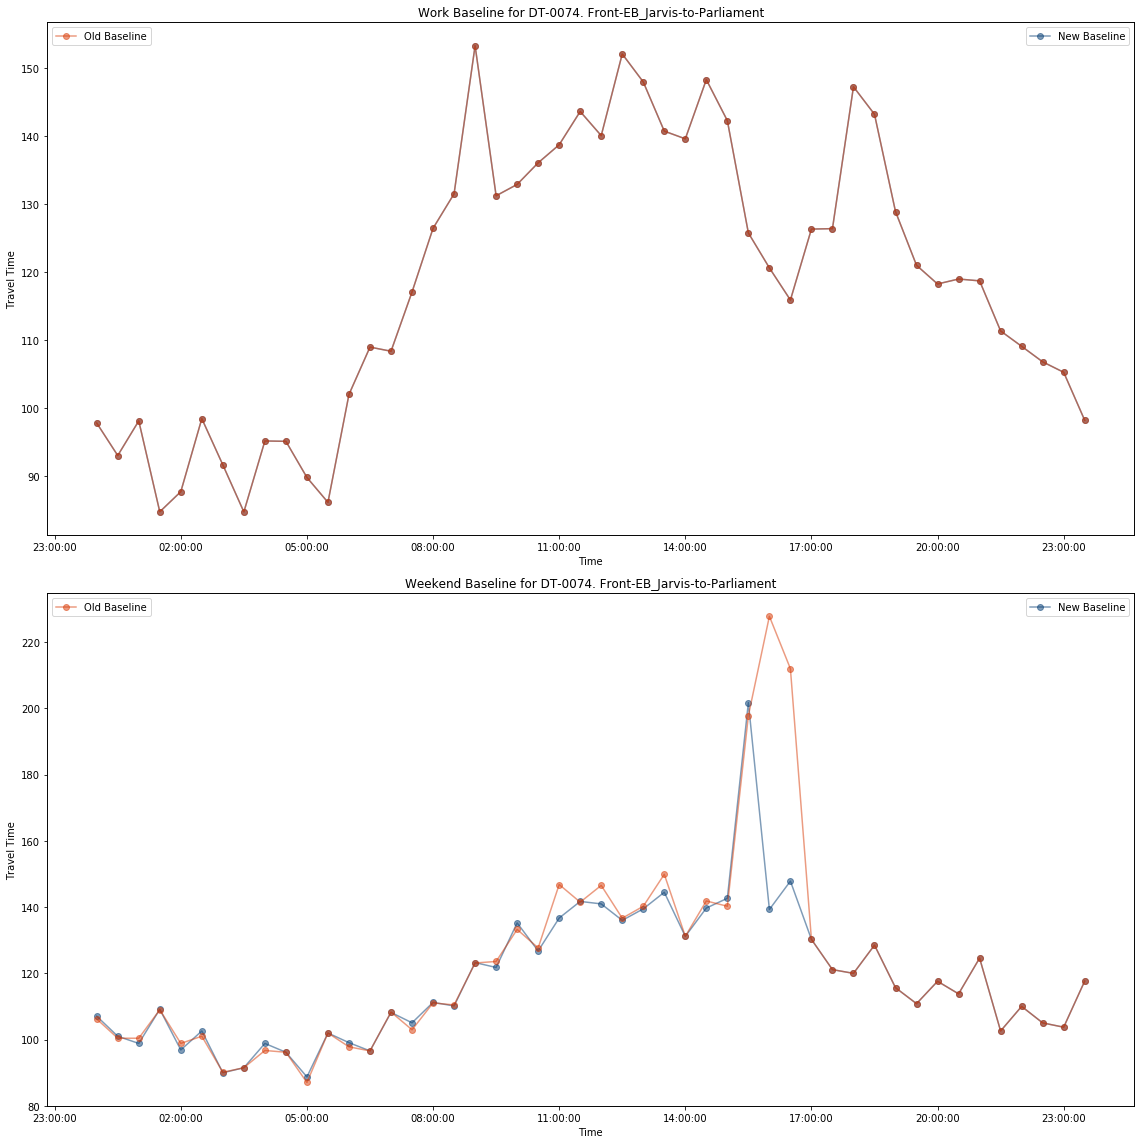

In [24]:
r_name = "DT-0074. Front-EB_Jarvis-to-Parliament"
plot_weeks(r_name, 37)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-16'])

Removing September 16th from this baseline had a major impact on the peak hour during the weekend.

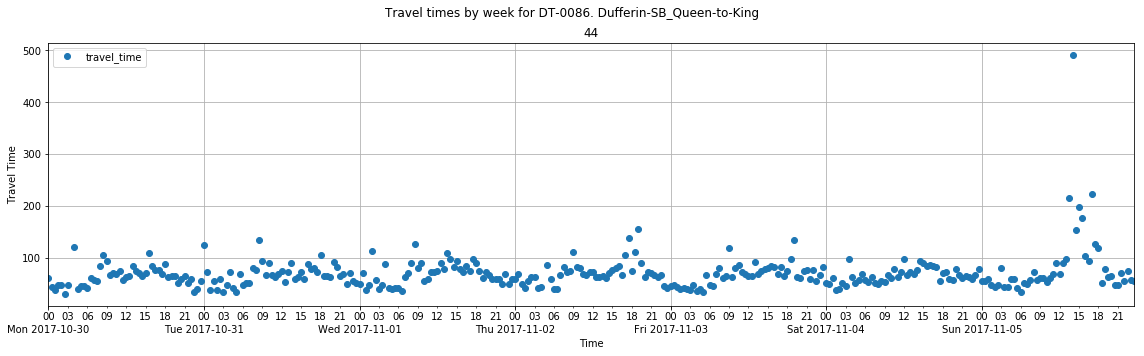

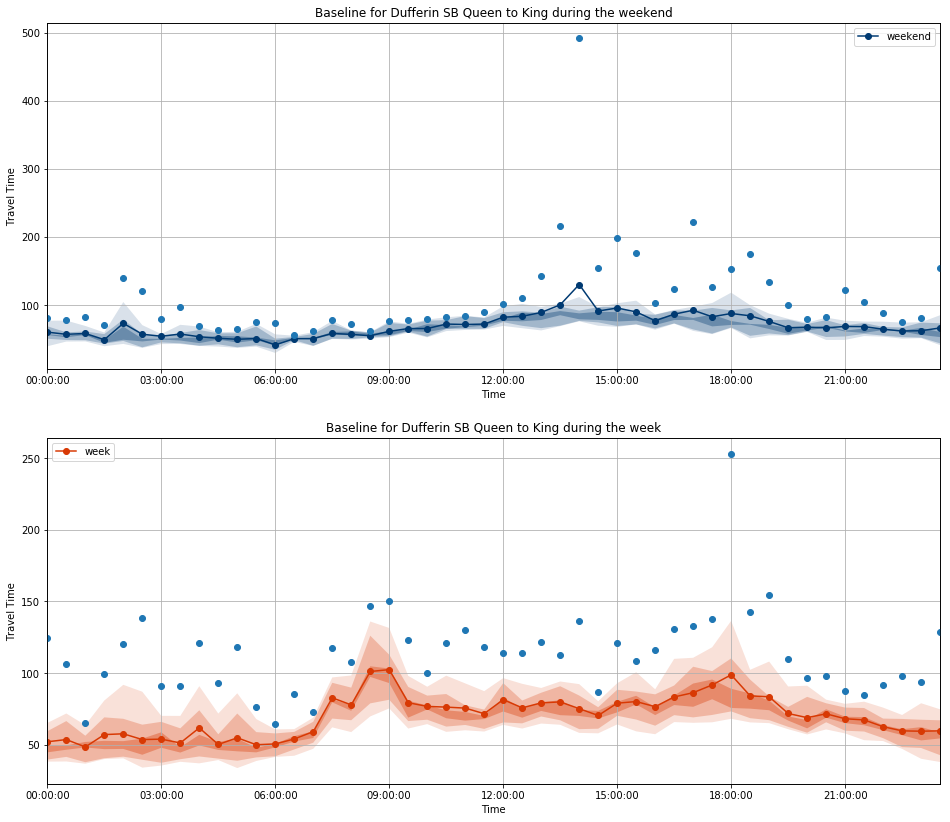

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


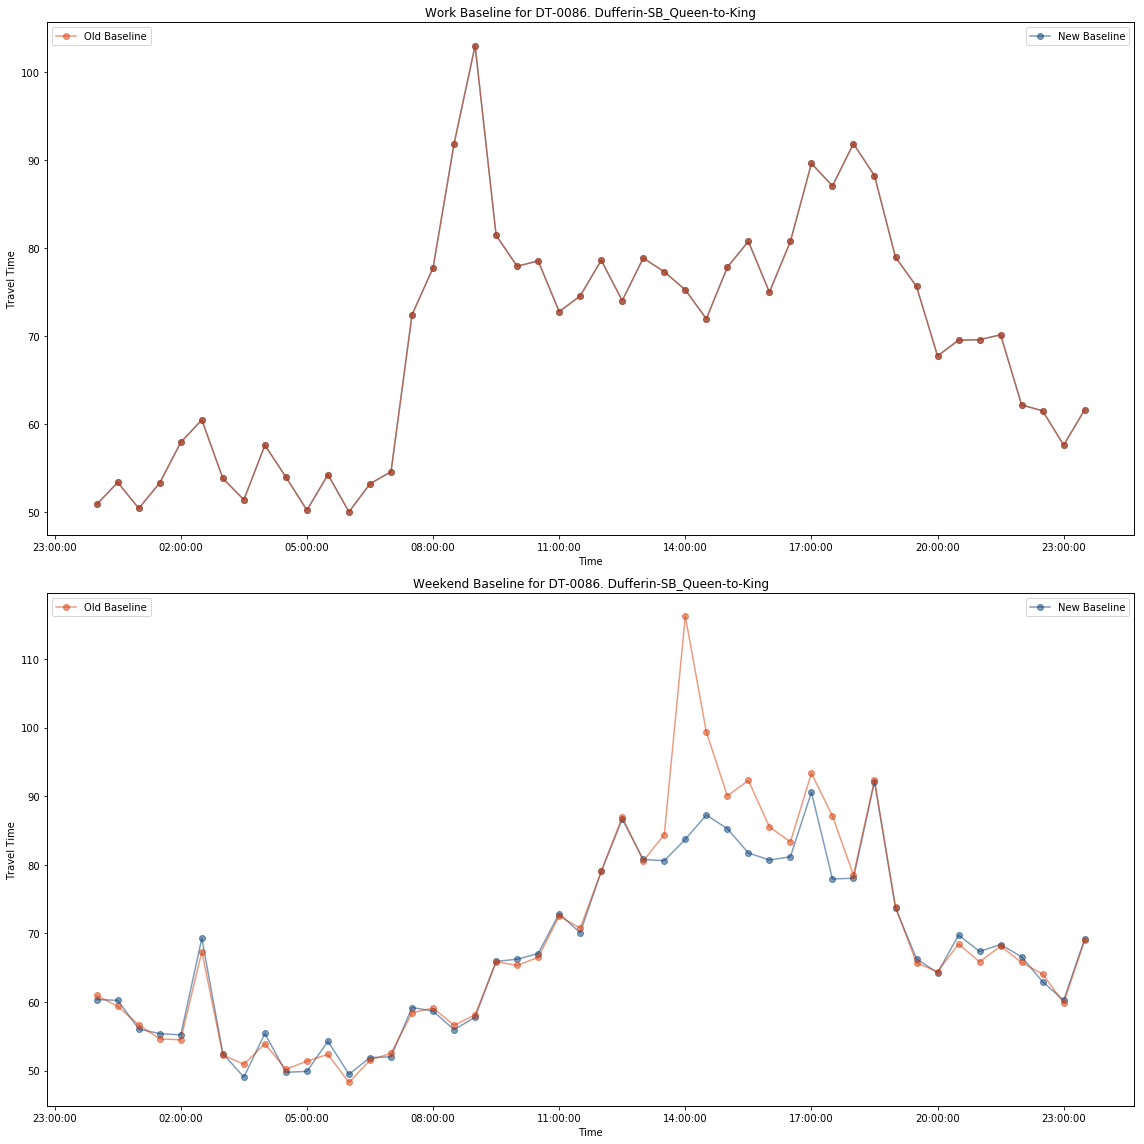

In [25]:
r_name = "DT-0086. Dufferin-SB_Queen-to-King"
plot_weeks(r_name, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-11-05'])

By removing November 5th, the weekend baseline changed in a major way around peak PM hour.

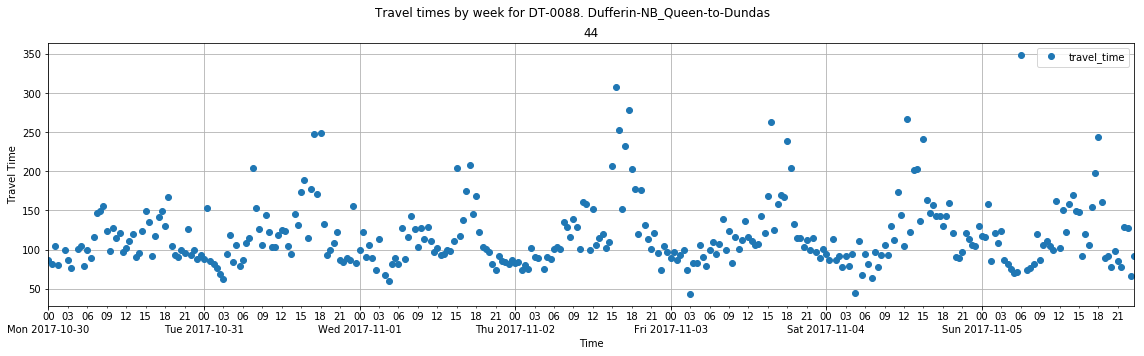

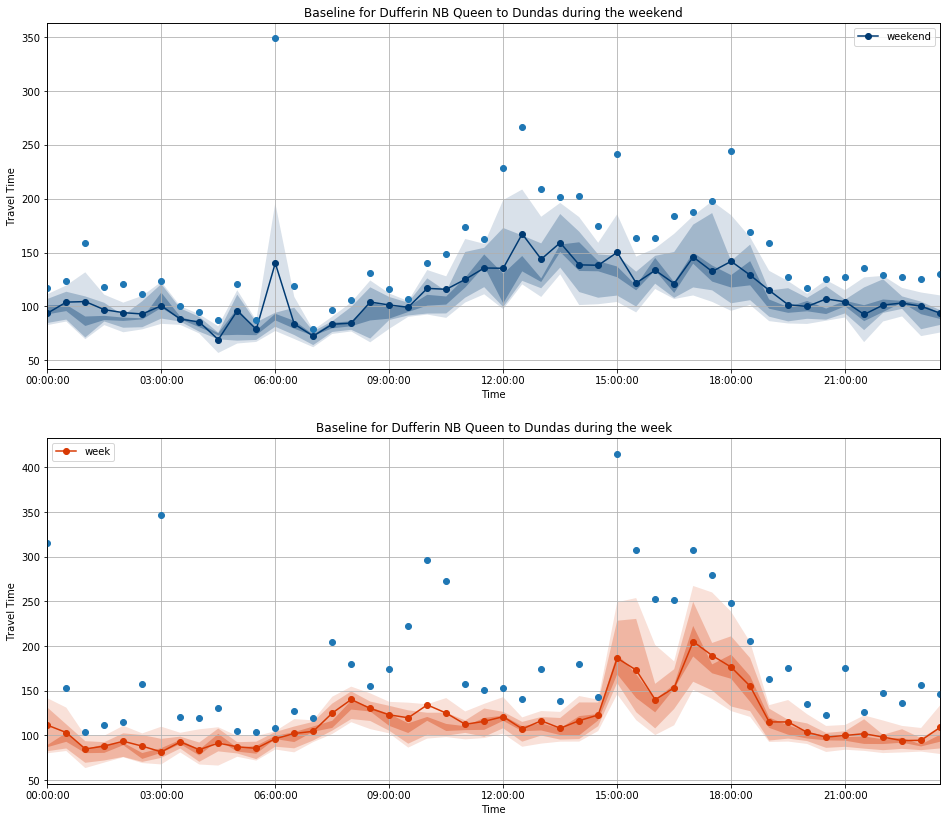

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


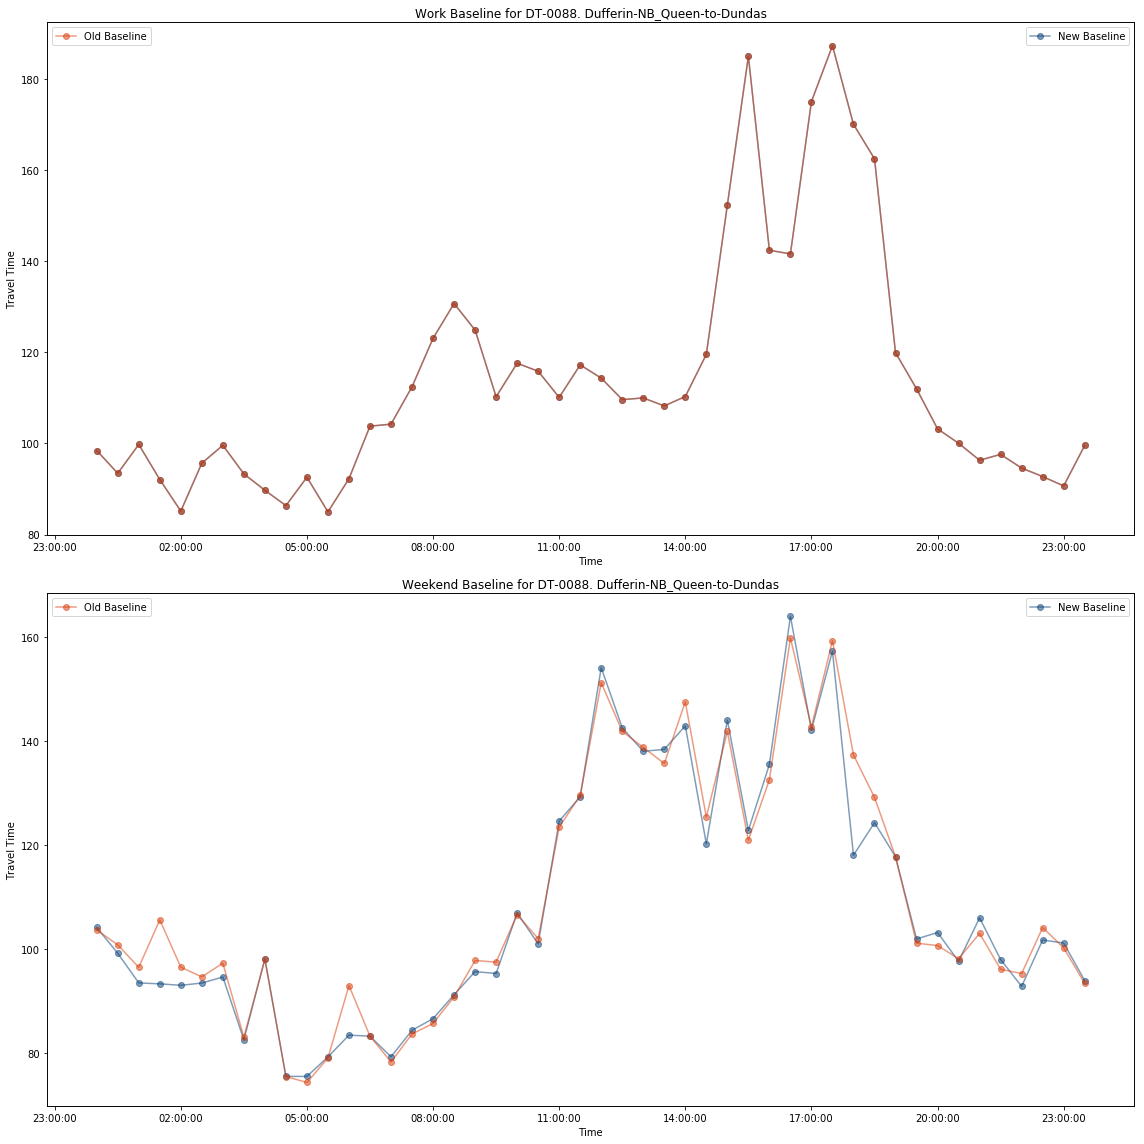

In [26]:
r_name = "DT-0088. Dufferin-NB_Queen-to-Dundas"
plot_weeks(r_name, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-11-05'])

Removing November 5th had a notable impact in the early and mid morning.

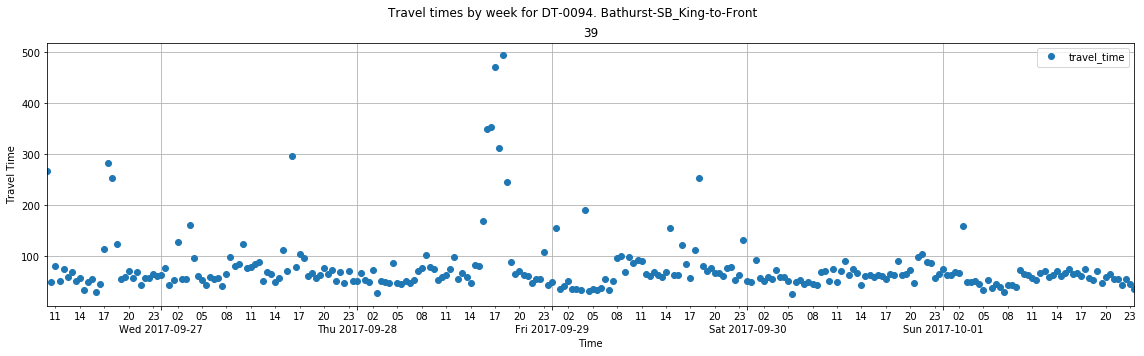

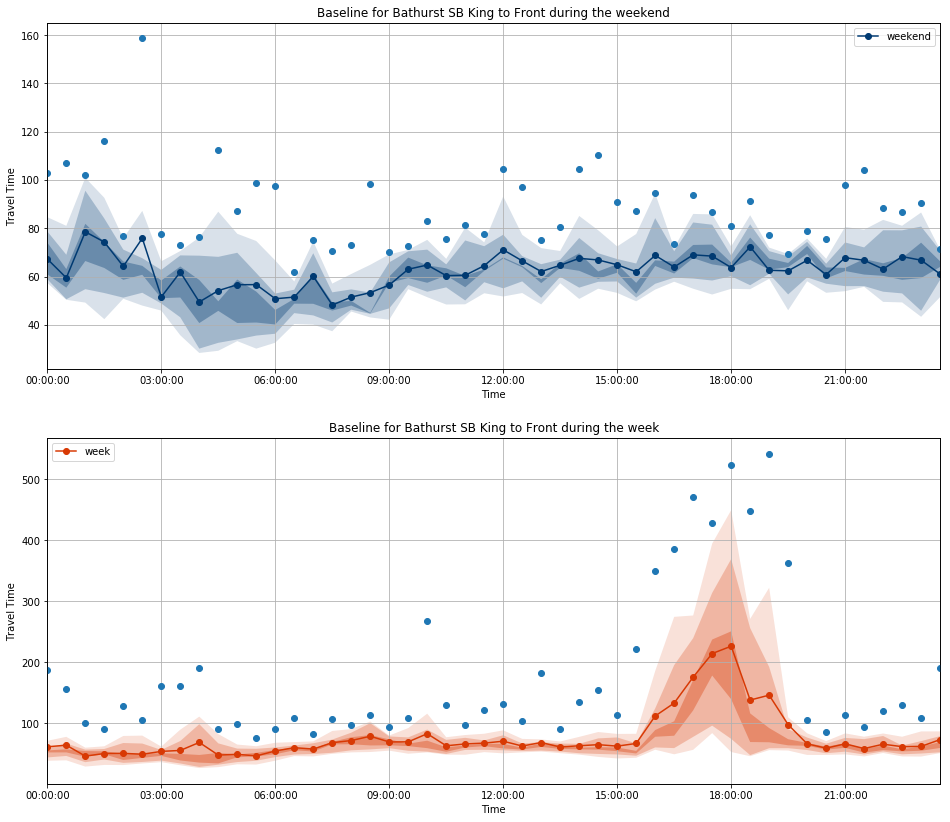

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


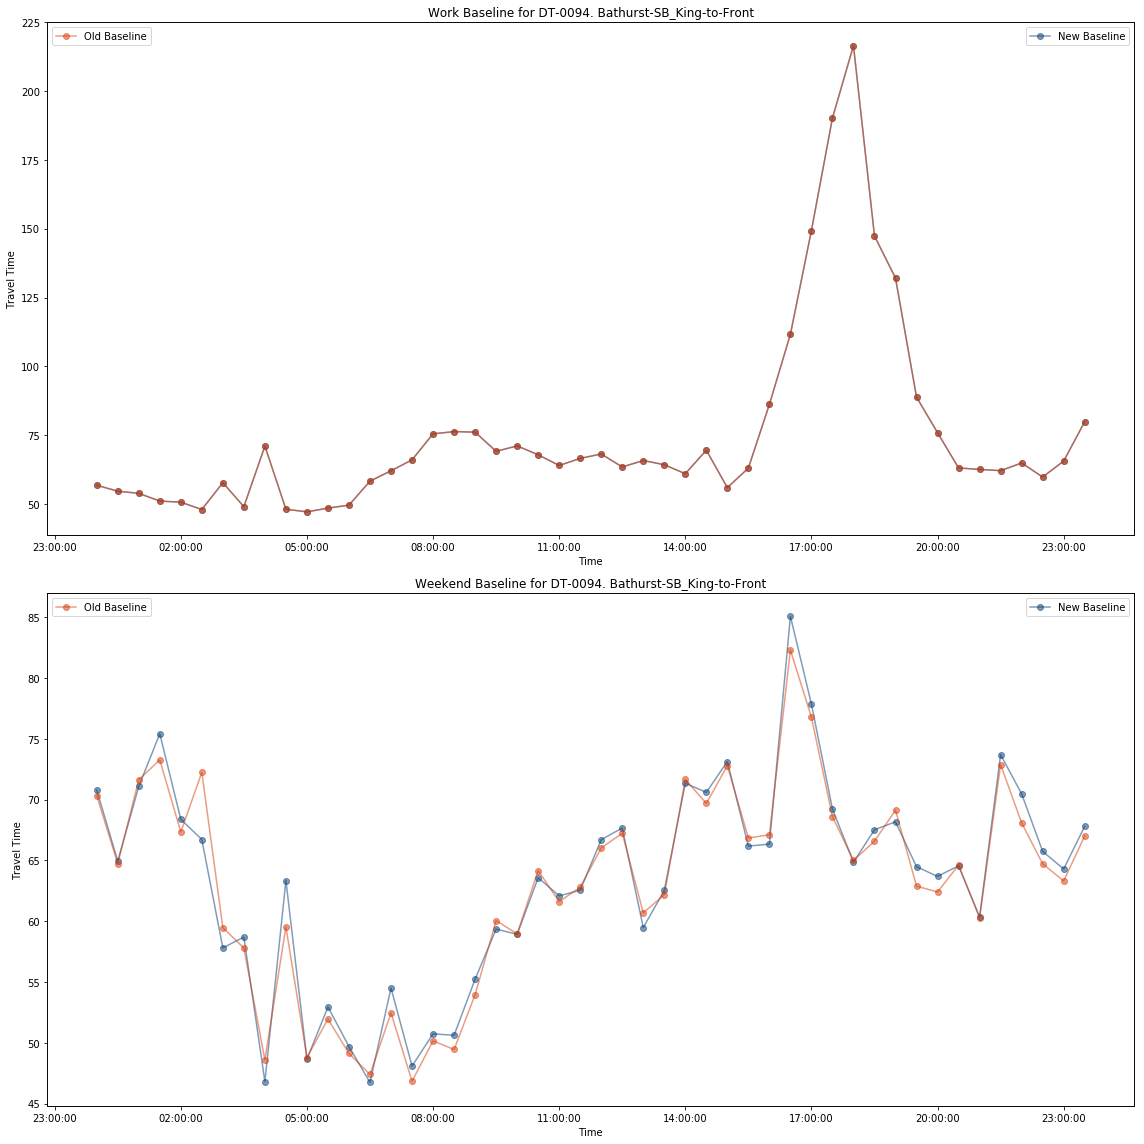

In [27]:
r_name = "DT-0094. Bathurst-SB_King-to-Front"
plot_weeks(r_name, 39)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-01'])

This outlier was minor and didn't affect the baseline.

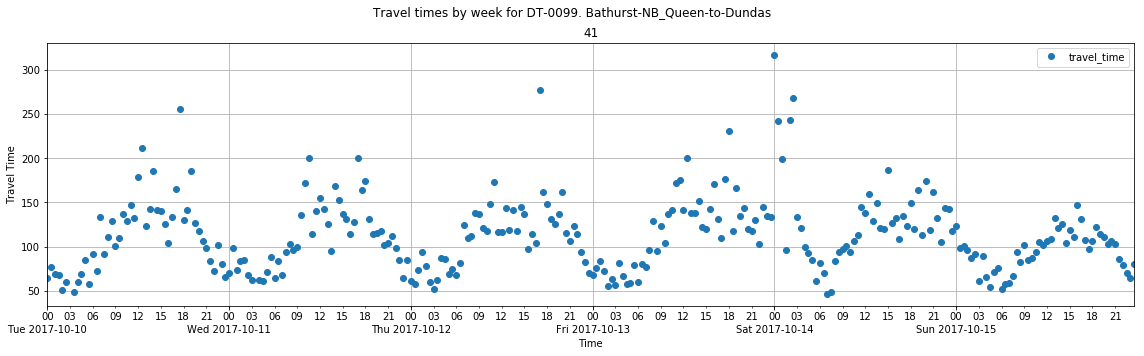

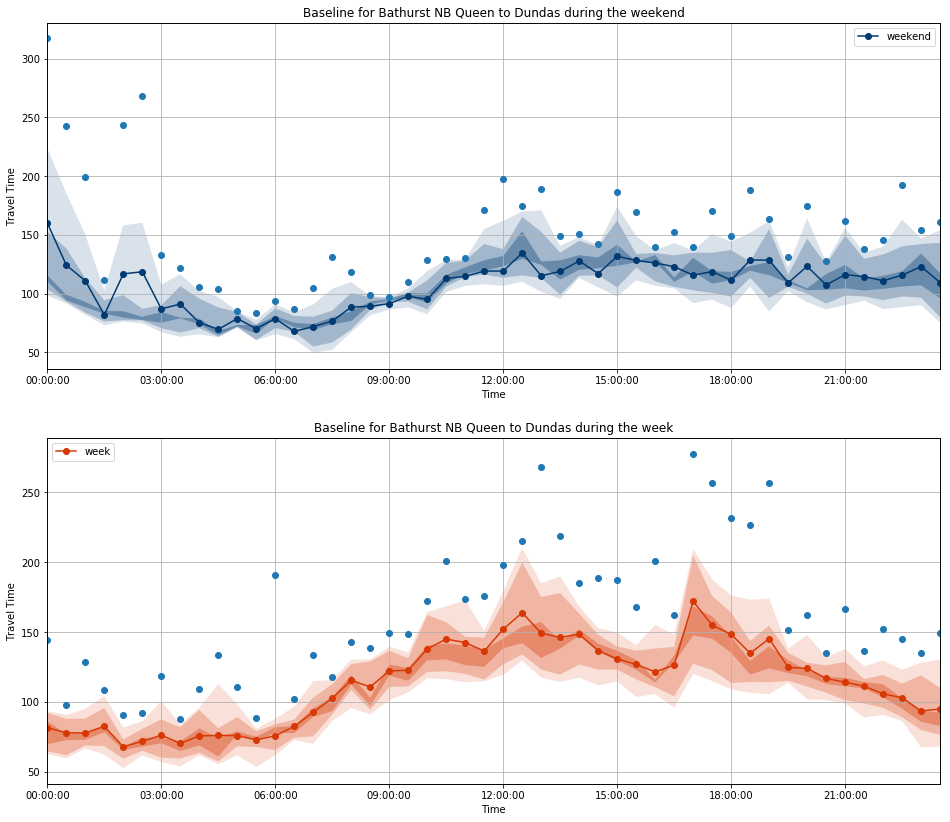

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


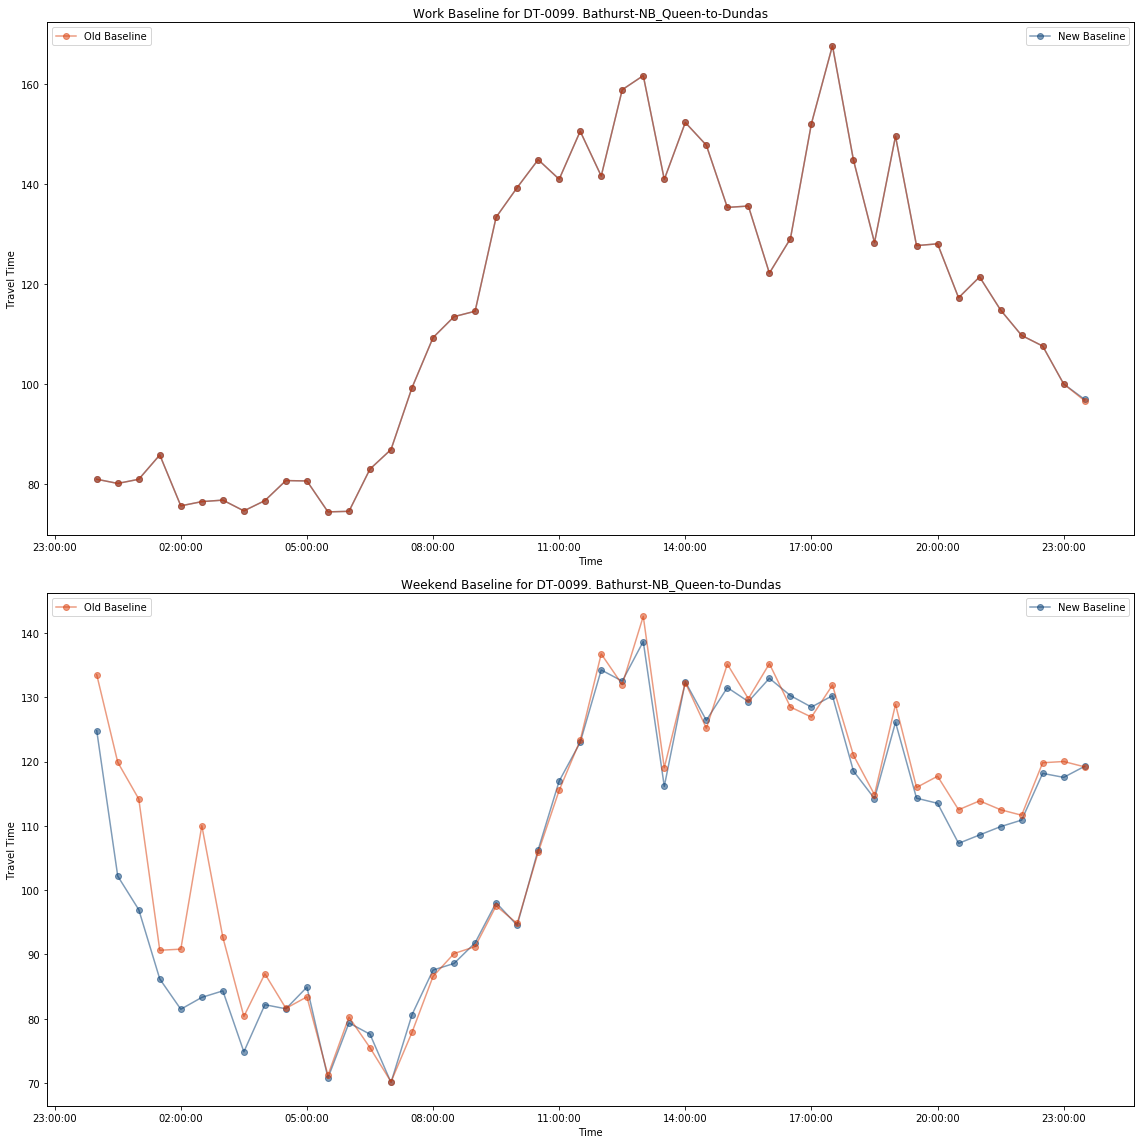

In [28]:
r_name = "DT-0099. Bathurst-NB_Queen-to-Dundas"
plot_weeks(r_name, 41)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-14'])

Removing October 14th had a significant impact on the early morning of the weekend baseline.

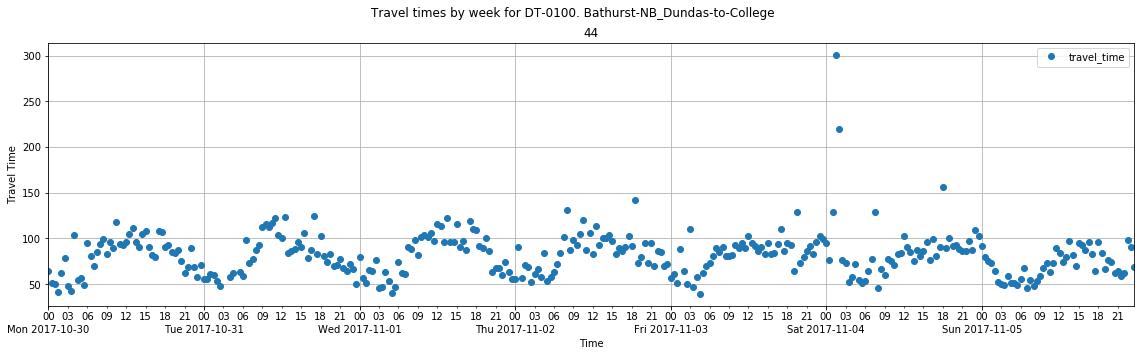

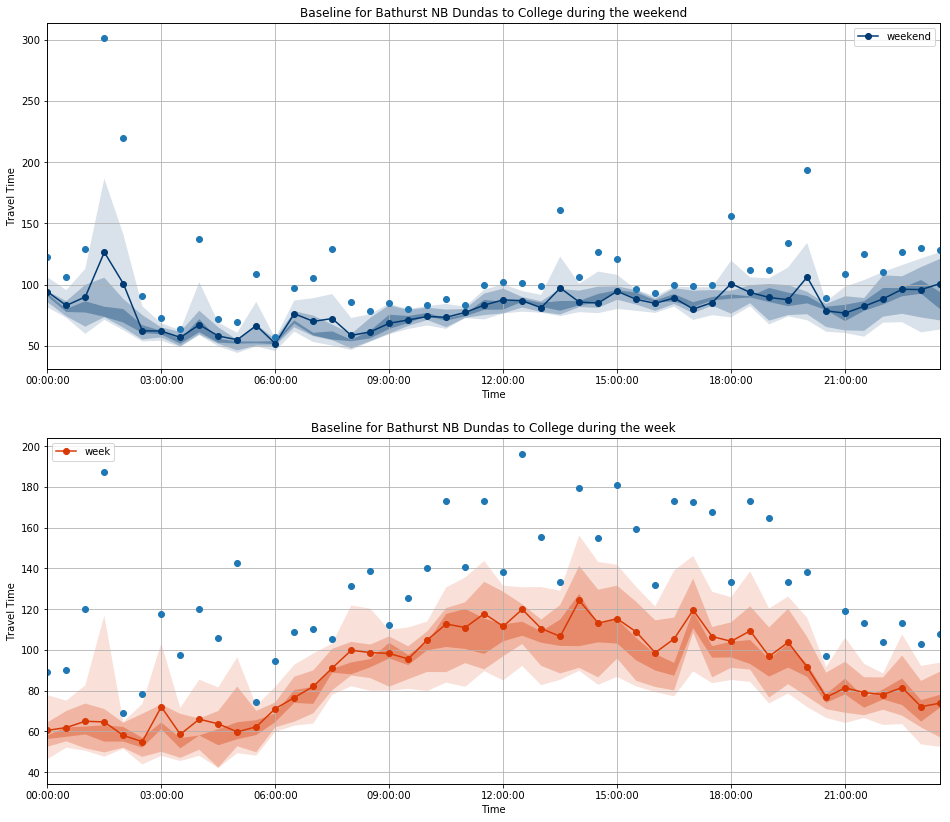

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


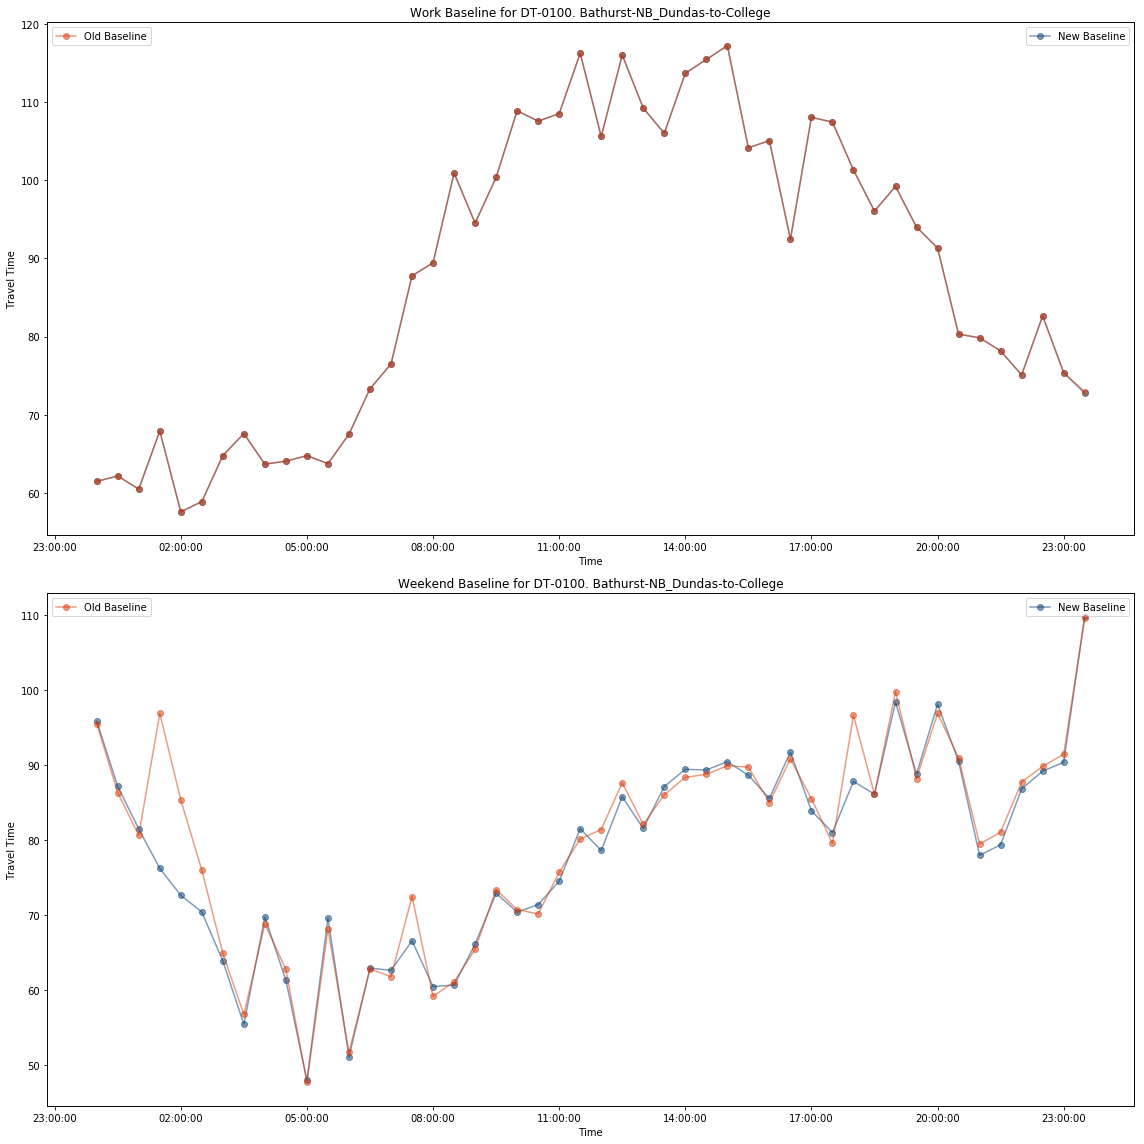

In [29]:
r_name = "DT-0100. Bathurst-NB_Dundas-to-College"
plot_weeks(r_name, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-11-04'])

Removing November 4th had a significant impact on the early morning, morning, and evening weekend baseline

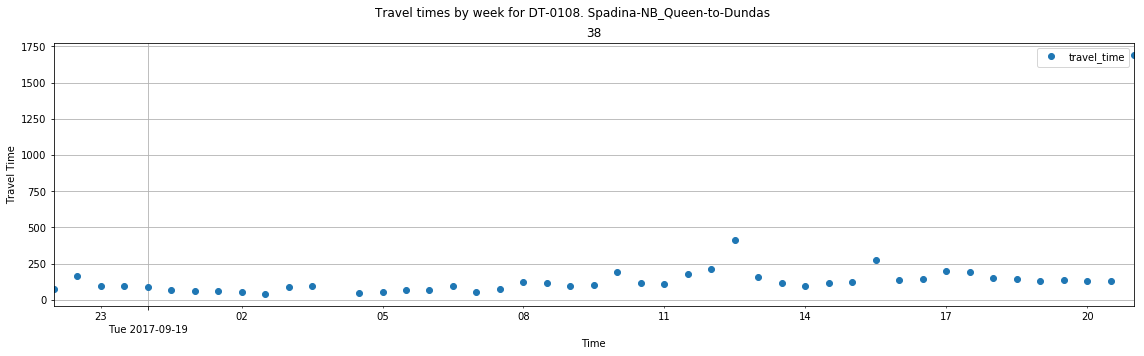

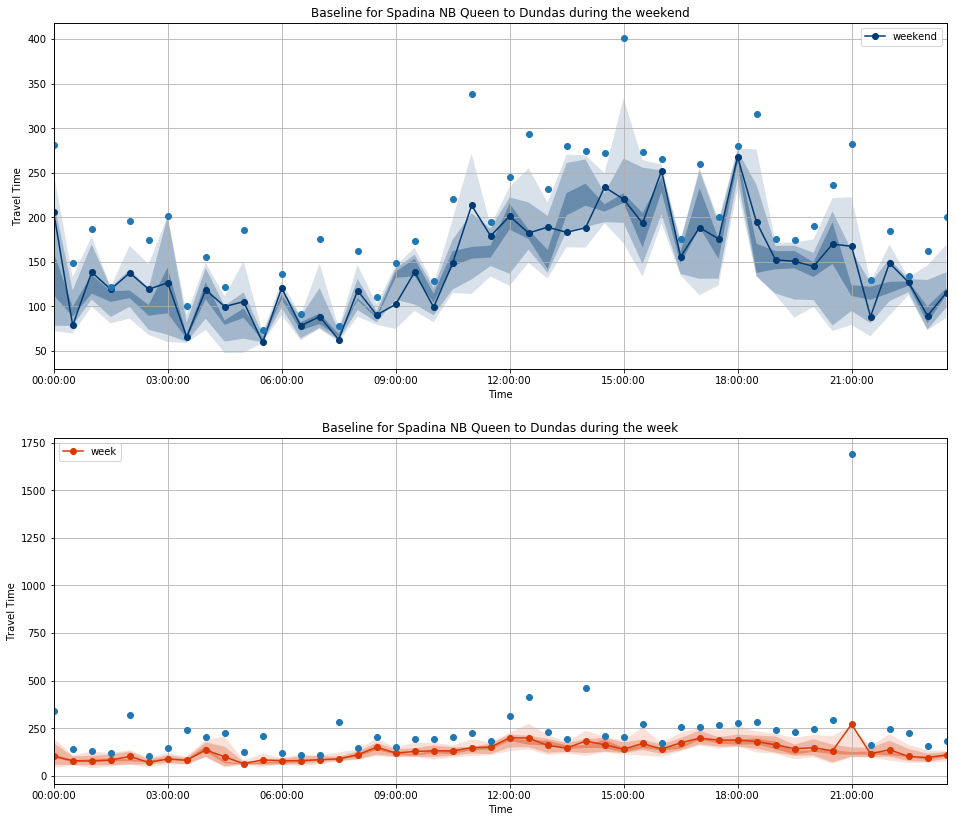

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


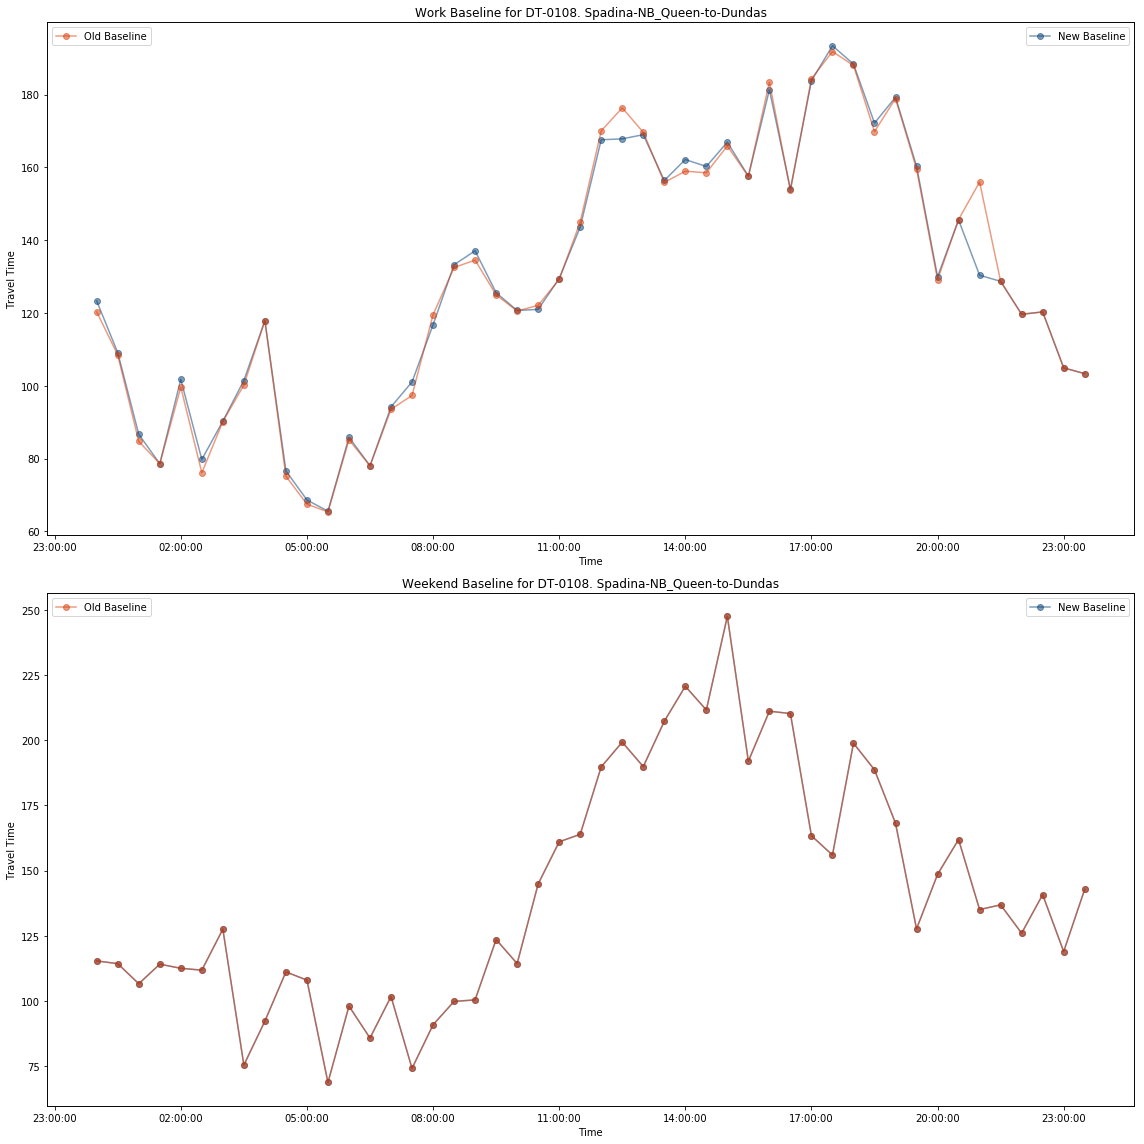

In [30]:
r_name = "DT-0108. Spadina-NB_Queen-to-Dundas"
plot_weeks(r_name, 38)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-19'])

Removing September 19th had a noticable impact on the weekday  baseline in the evening and at midday

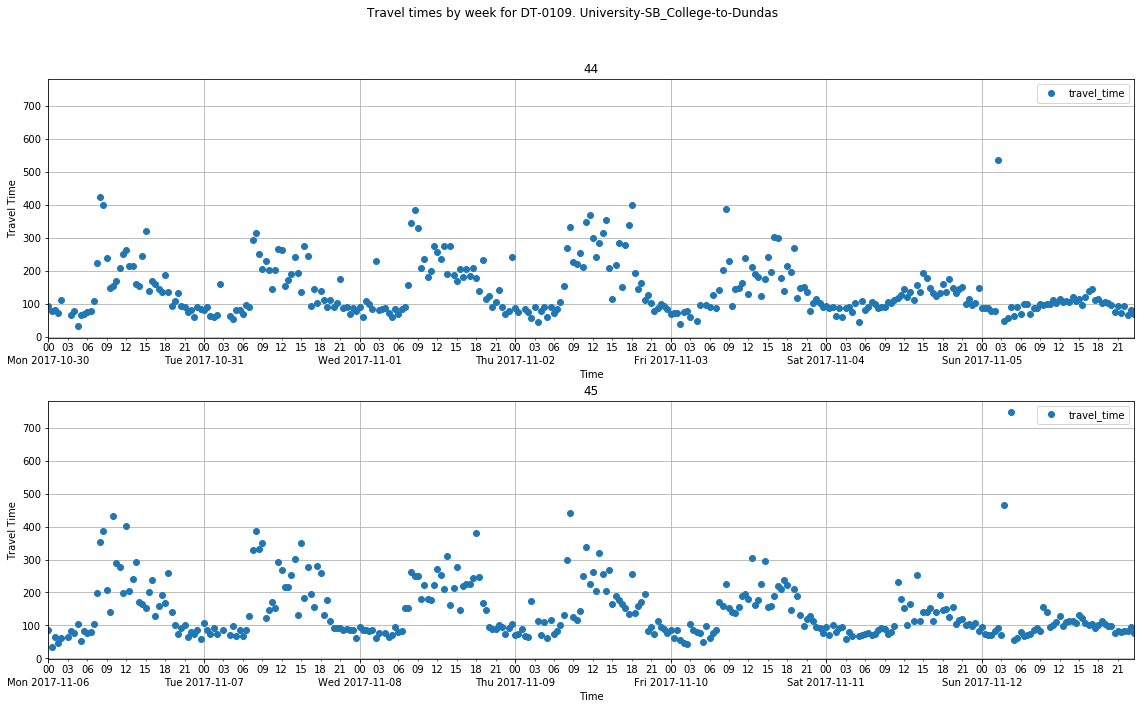

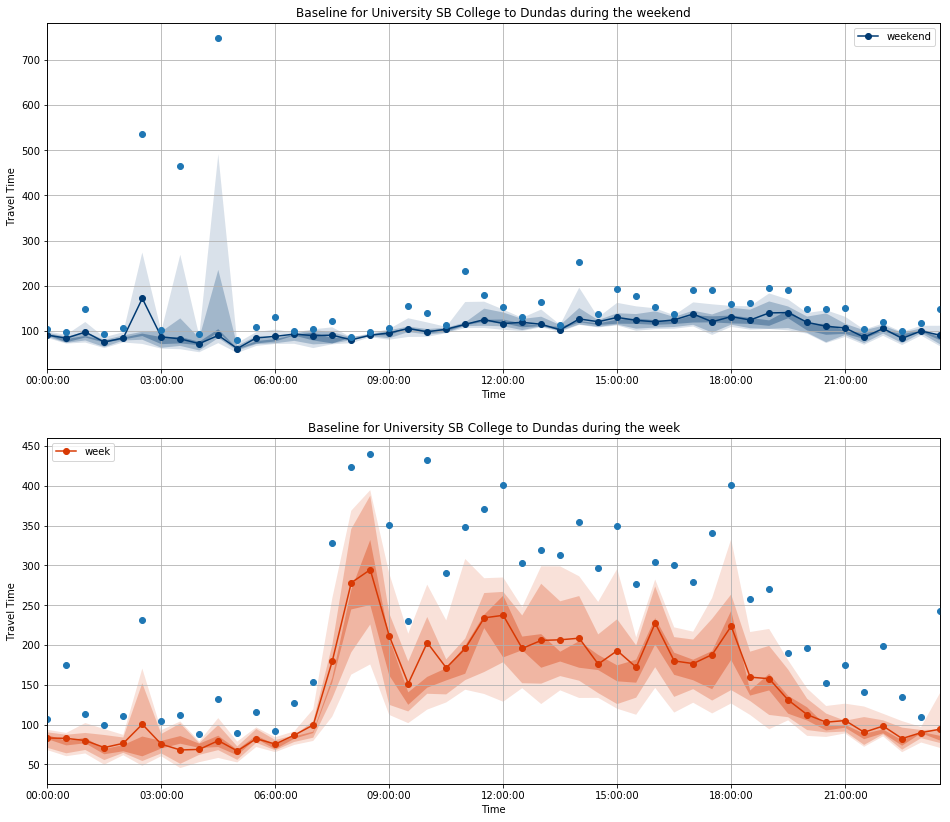

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


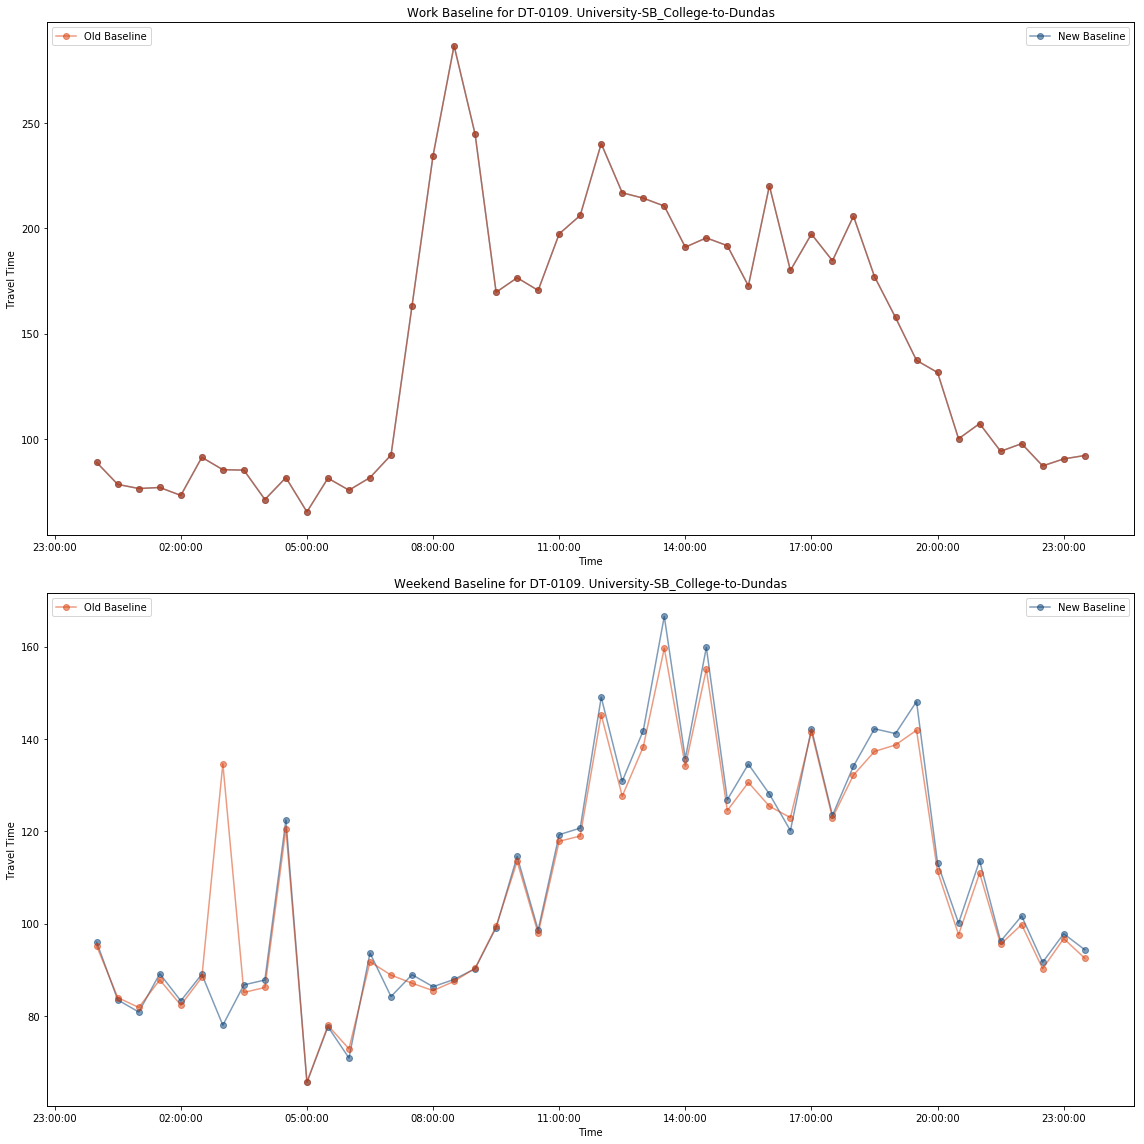

In [31]:
r_name = "DT-0109. University-SB_College-to-Dundas"
plot_weeks(r_name, 44, 45)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-11-05'])

Removing November 5th had a significant effect on the weekend baseline early in the morning.

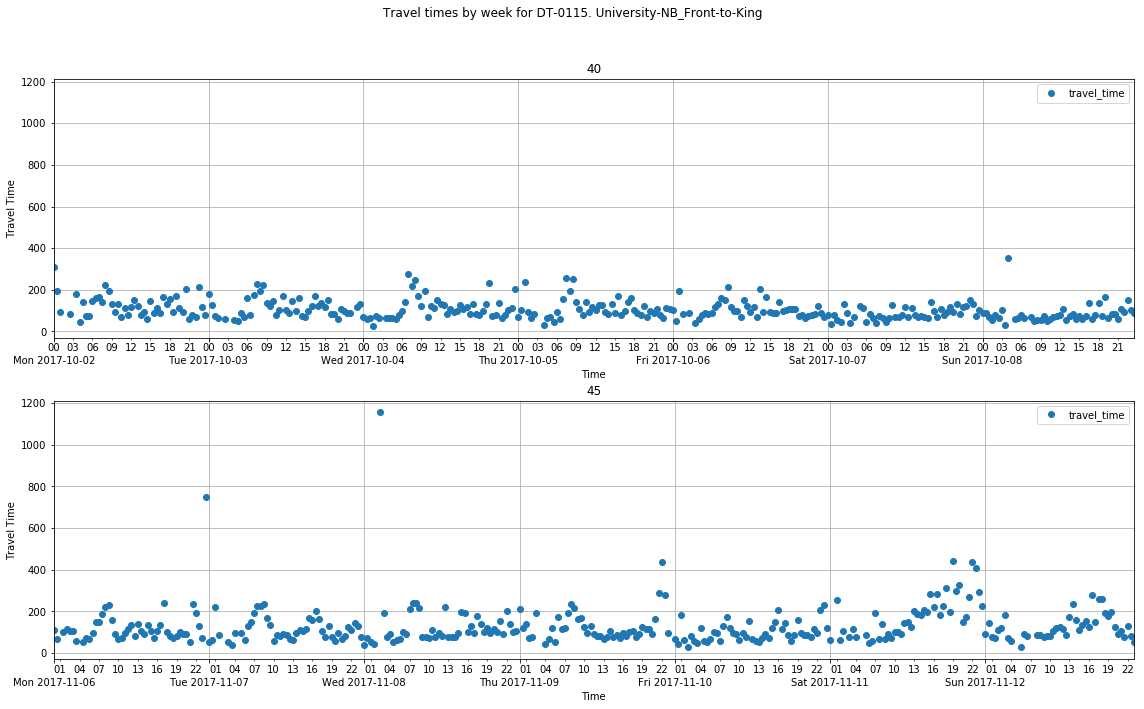

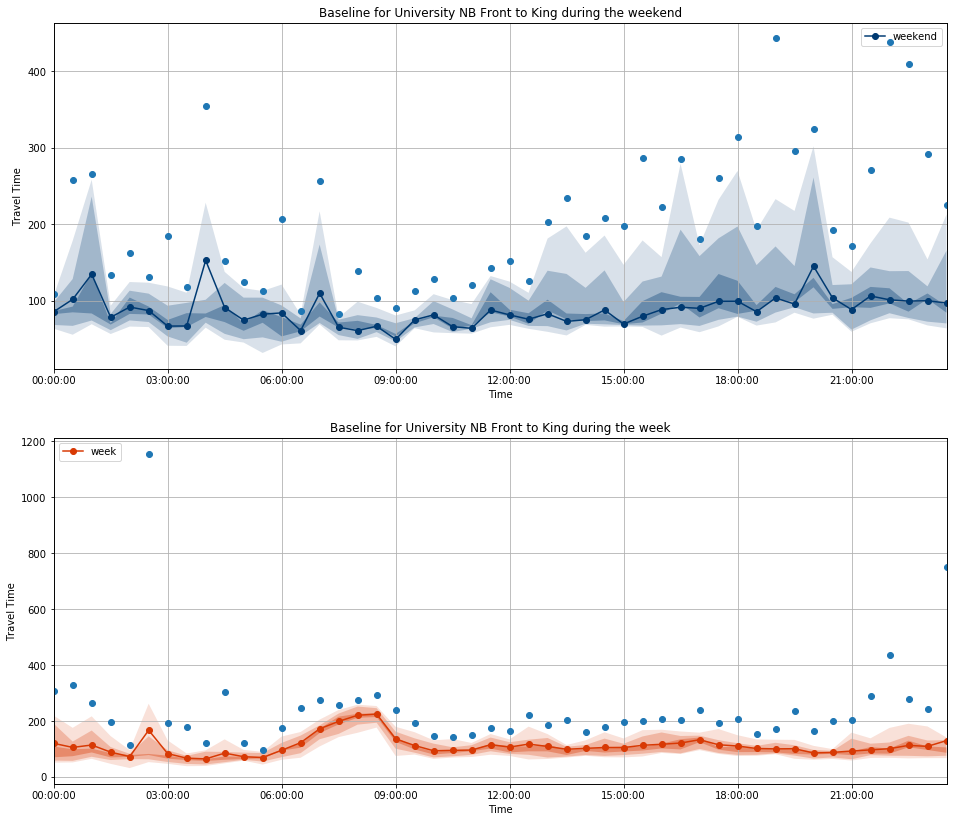

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


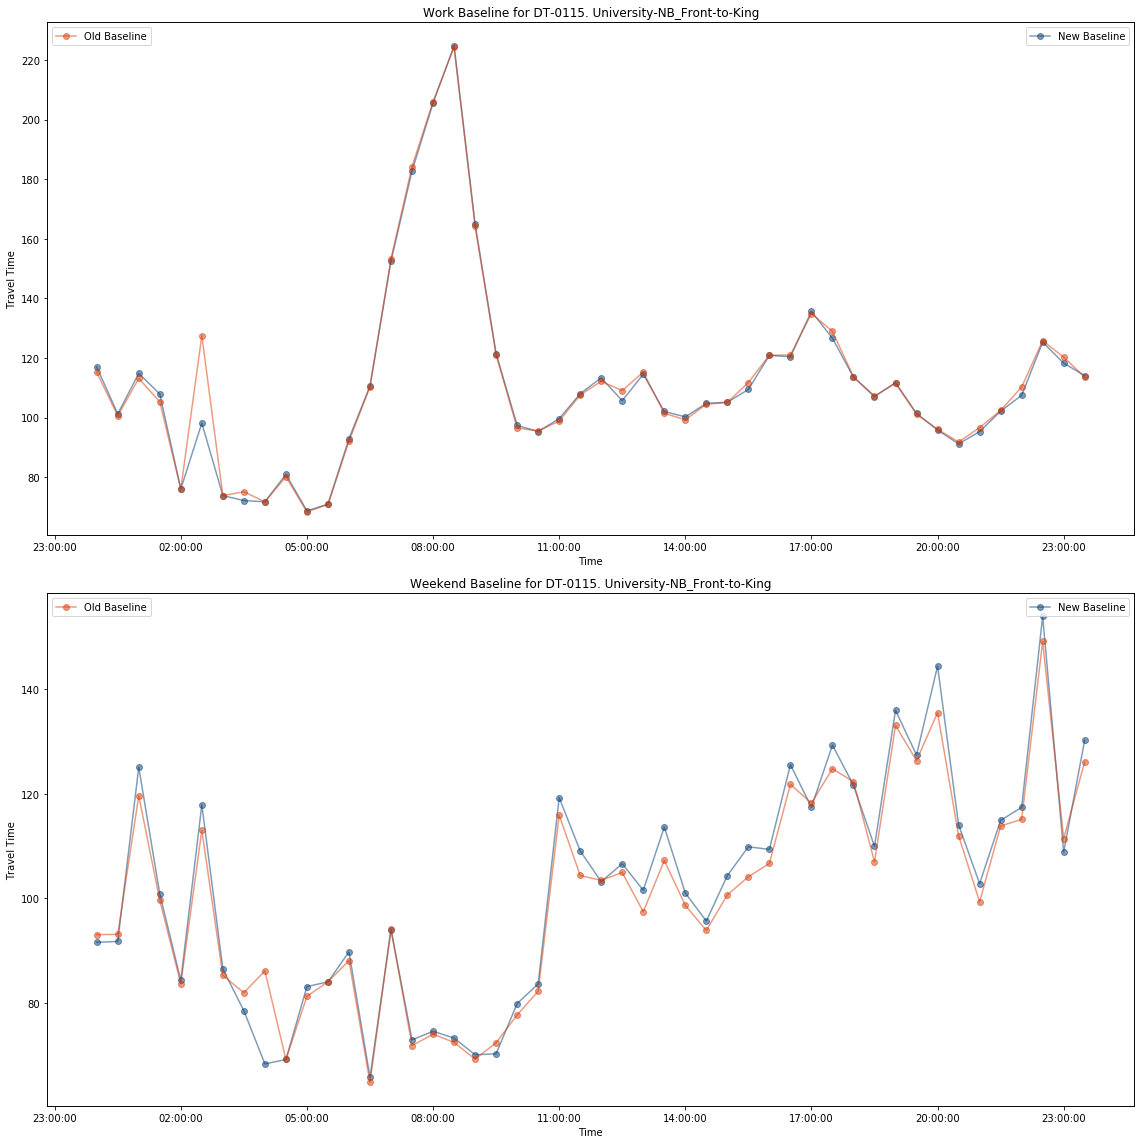

In [32]:
r_name = "DT-0115. University-NB_Front-to-King"
plot_weeks(r_name, 40, 45)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-10-08', '2017-11-08'])

Removing October and November 8th resulted in insignificant changes to the weekend baseline in the early morning.

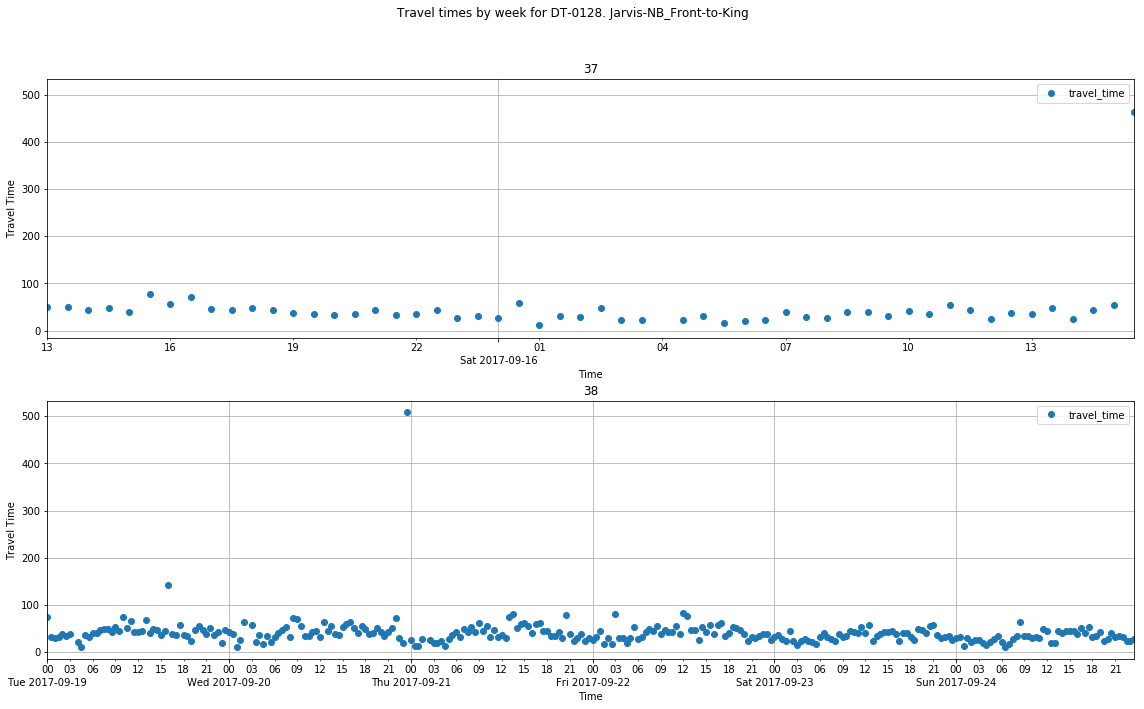

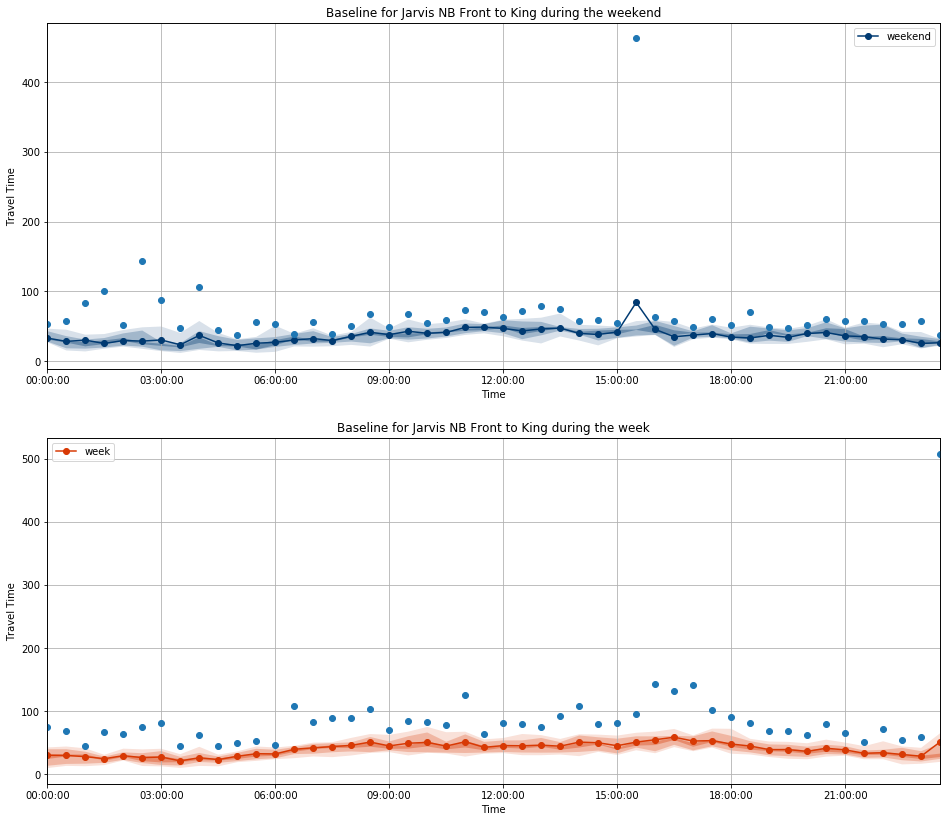

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


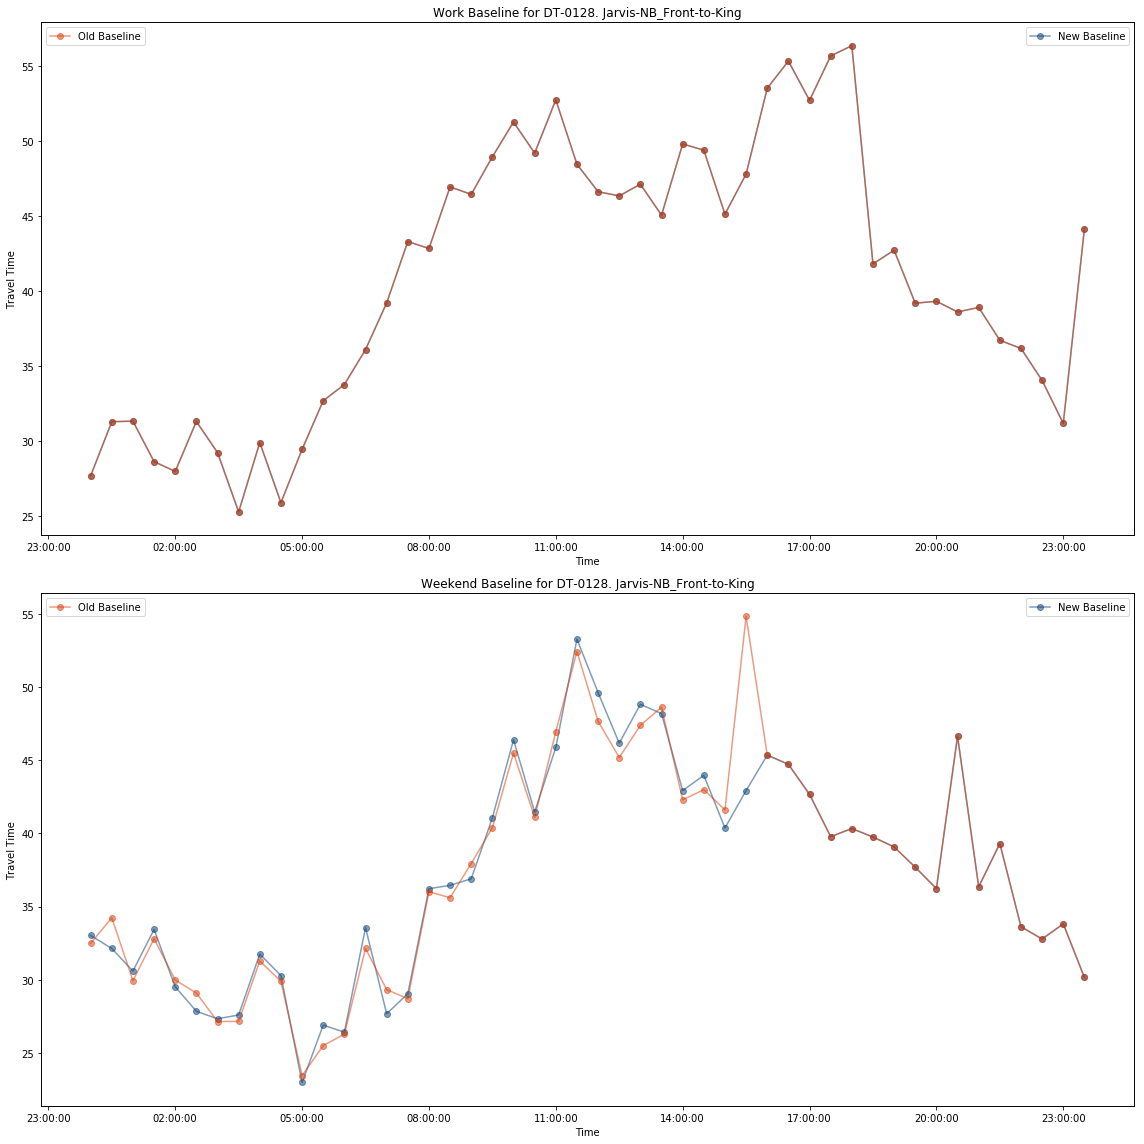

In [33]:
r_name = "DT-0128. Jarvis-NB_Front-to-King"
plot_weeks(r_name, 37, 38)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-16'])

Removing September 16th had a notable impact on the baseline during midday.

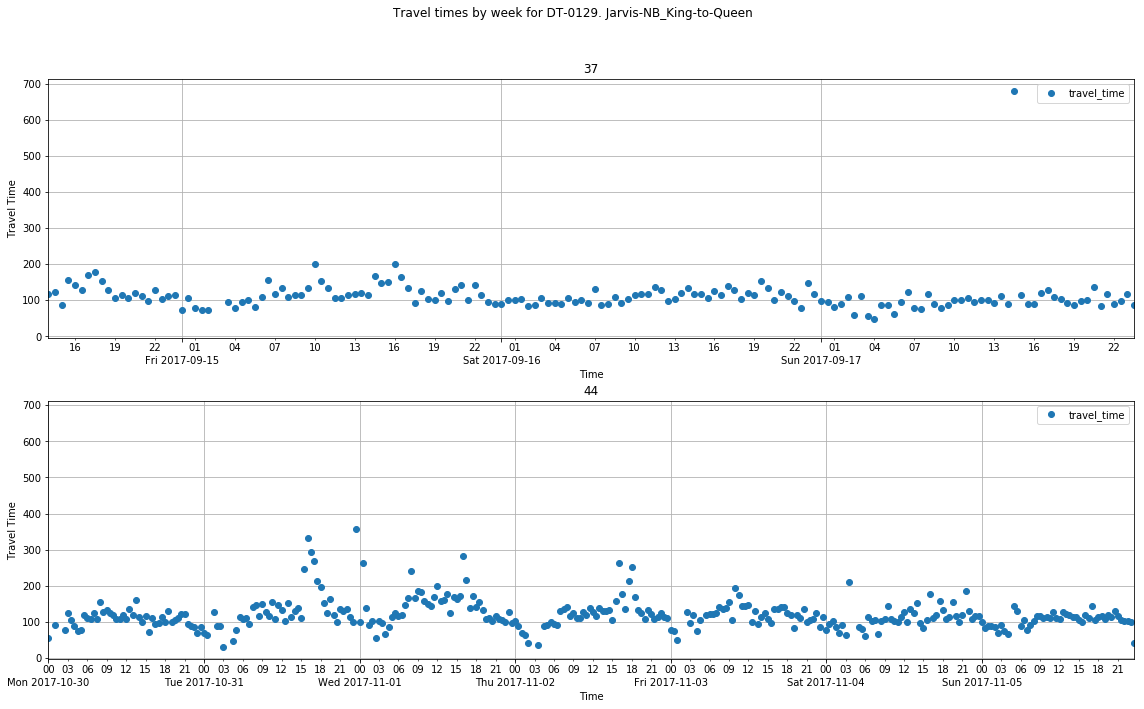

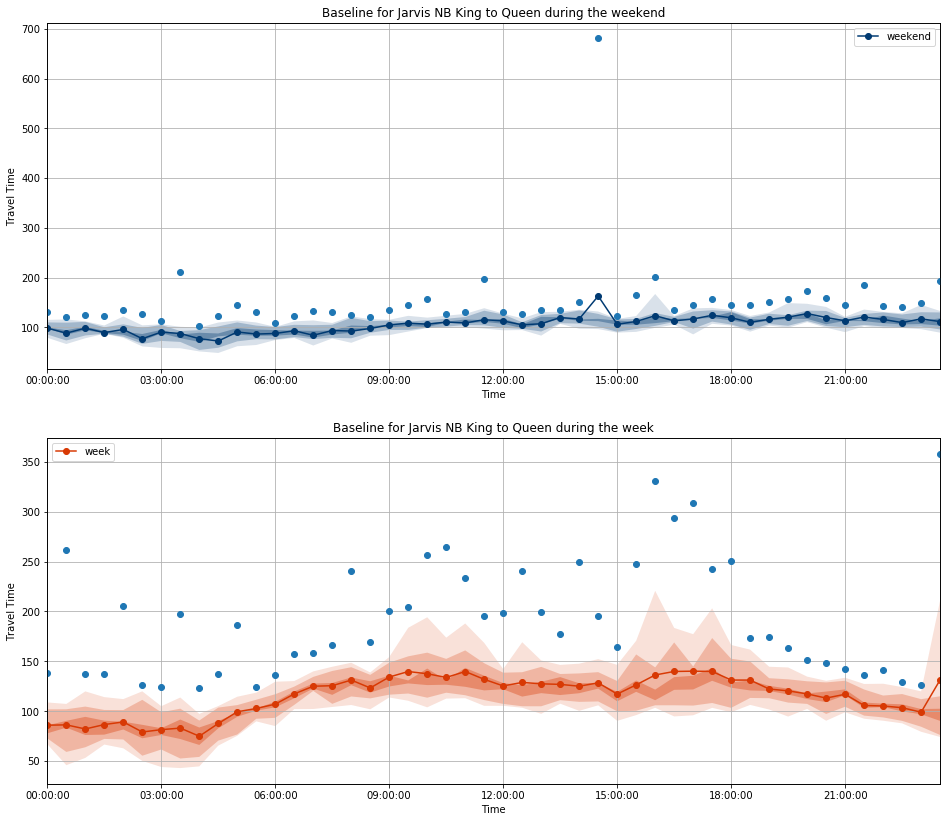

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


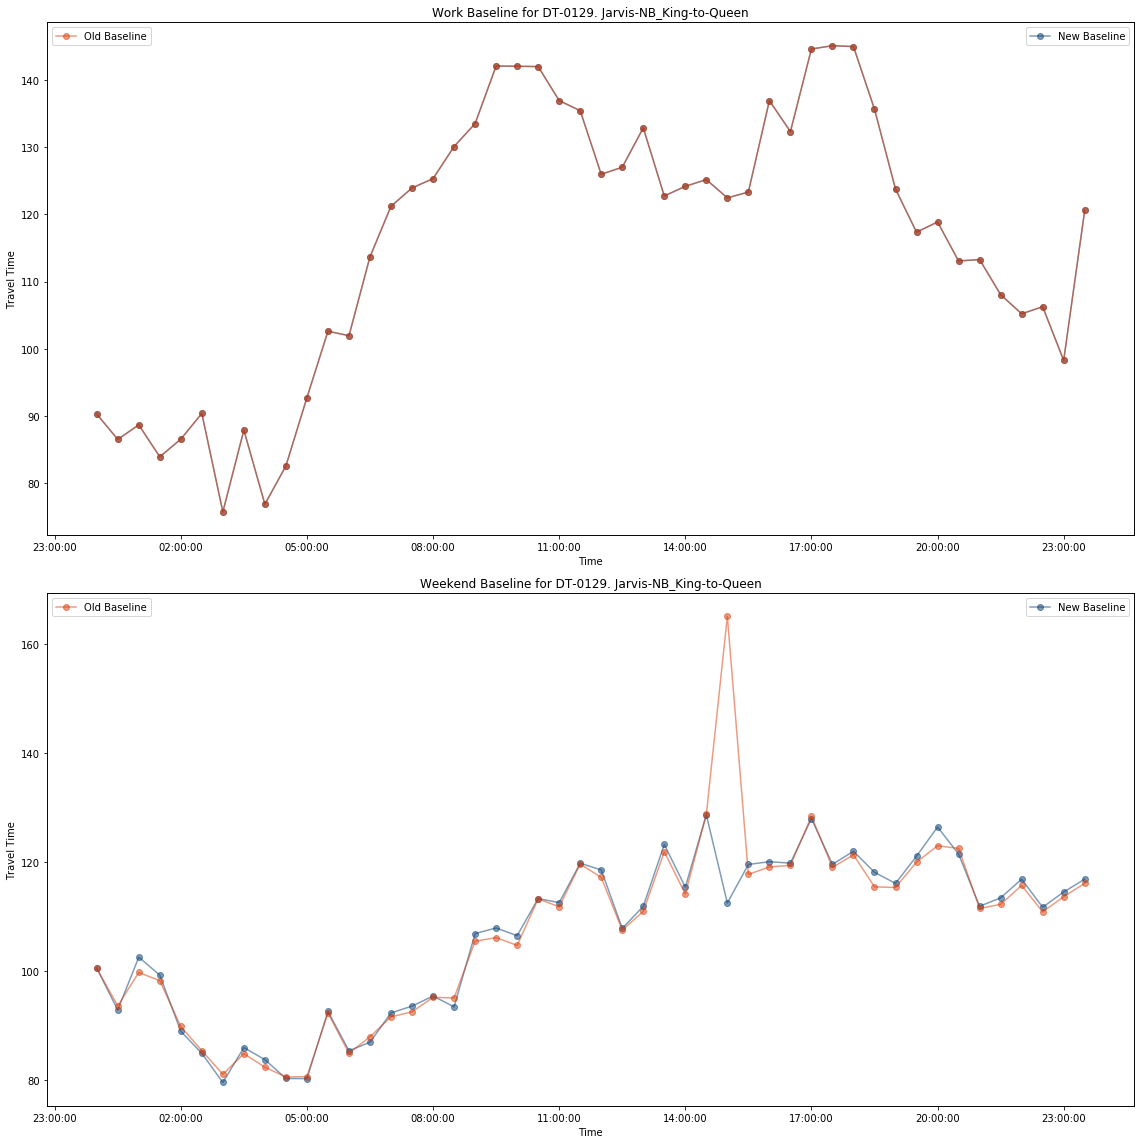

In [34]:
r_name = "DT-0129. Jarvis-NB_King-to-Queen"
plot_weeks(r_name, 37, 44)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-17'])

Removing September 17th had a significant impact on the weekend baseline during midday

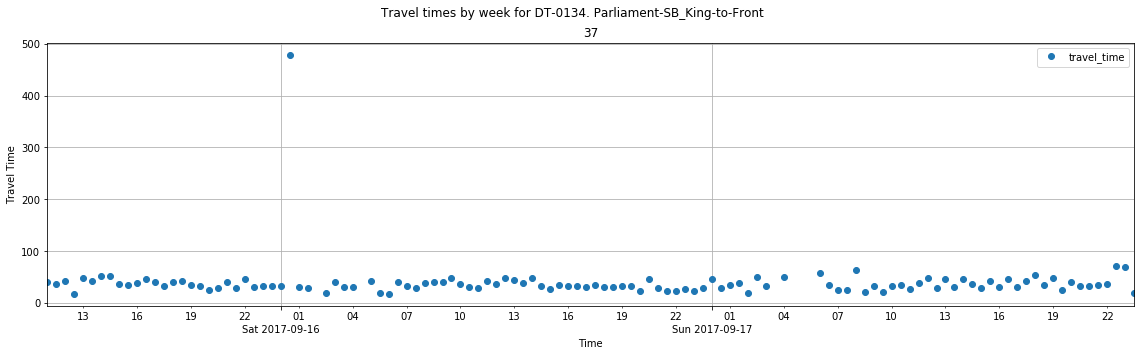

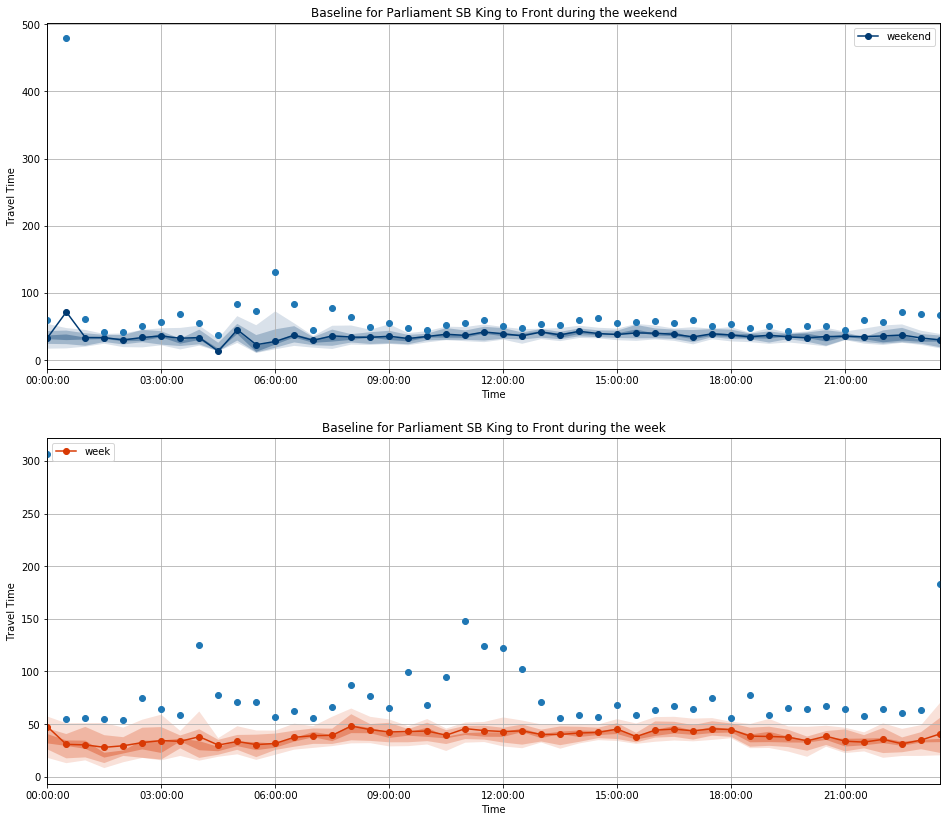

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


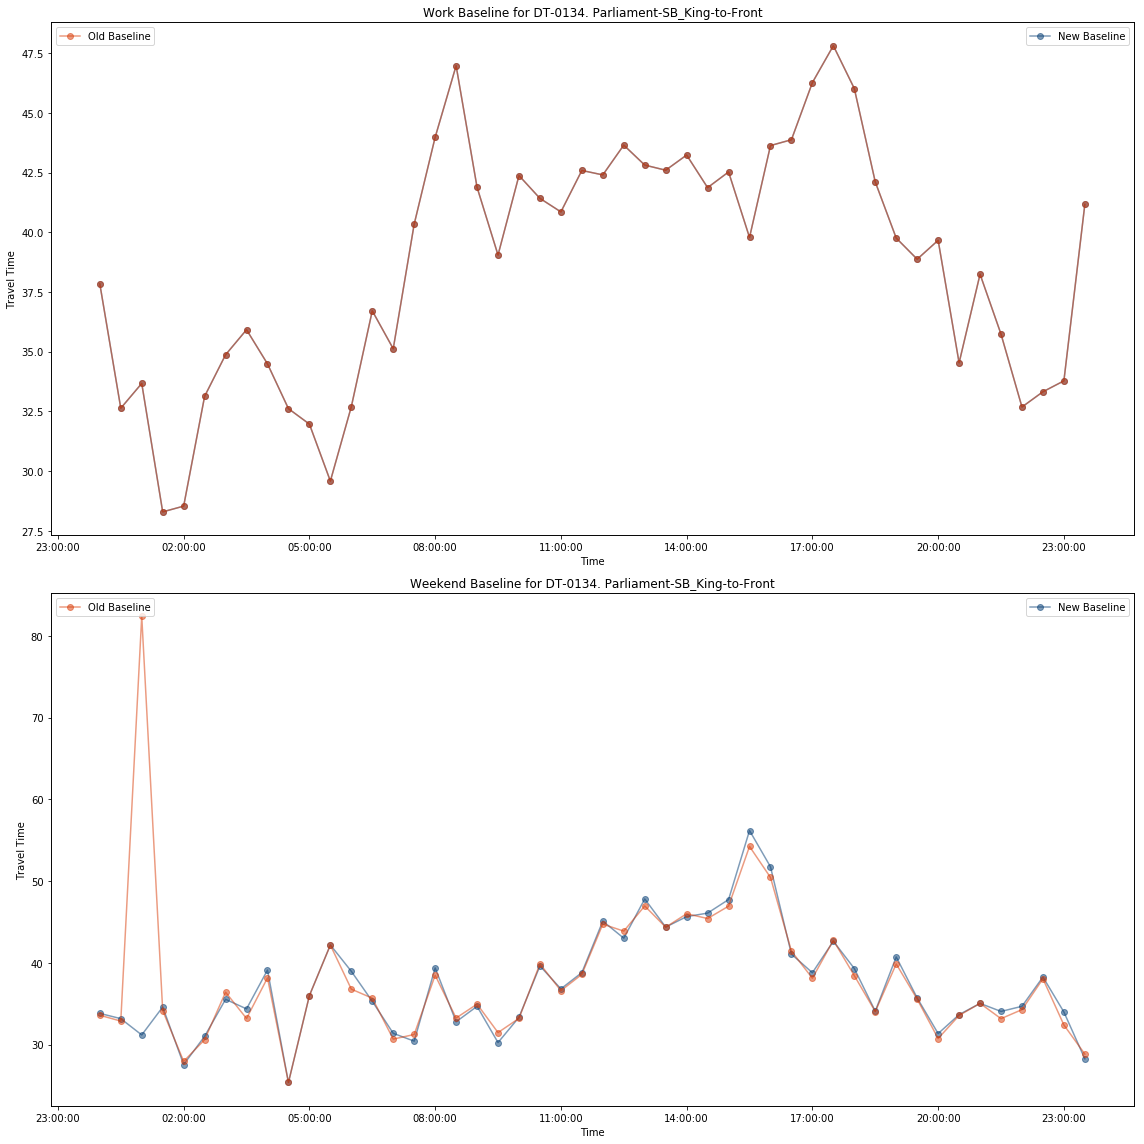

In [35]:
r_name = "DT-0134. Parliament-SB_King-to-Front"
plot_weeks(r_name, 37)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-16'])

Removing September 16th had a major impact on the weekend baseline early in the morning

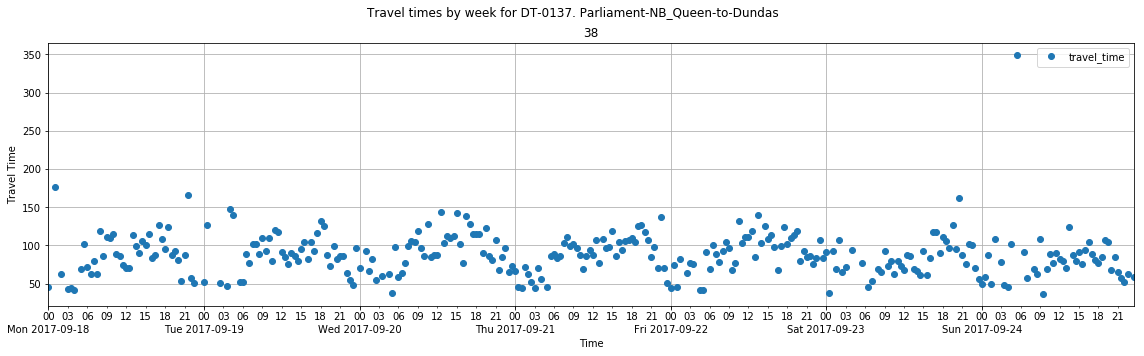

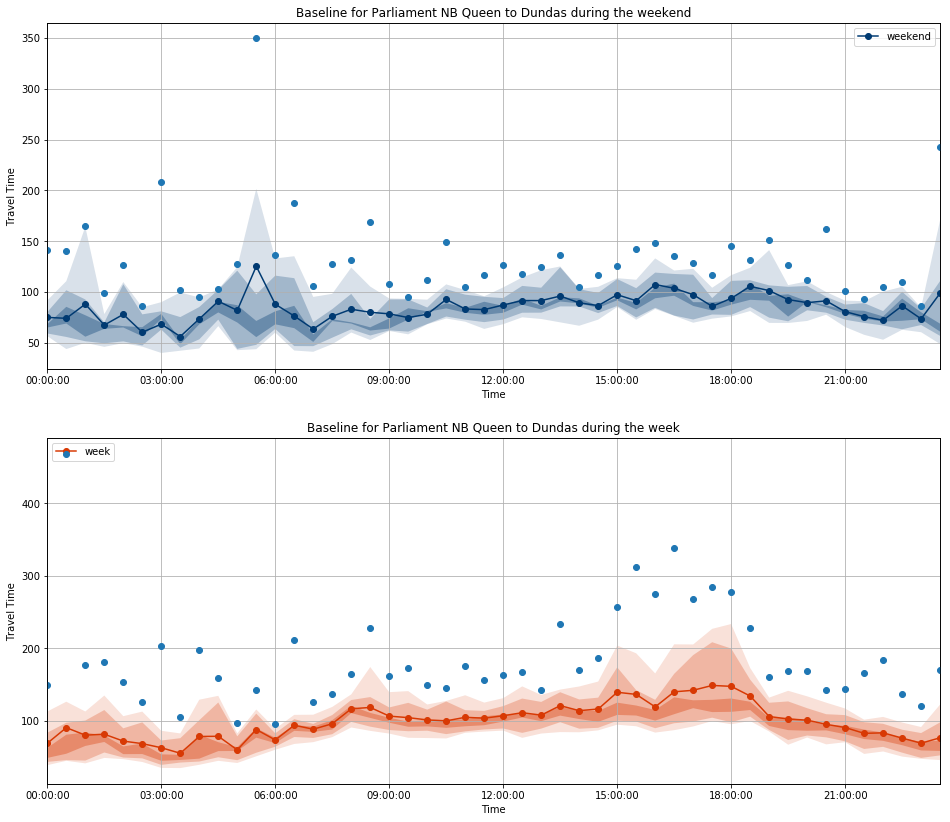

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


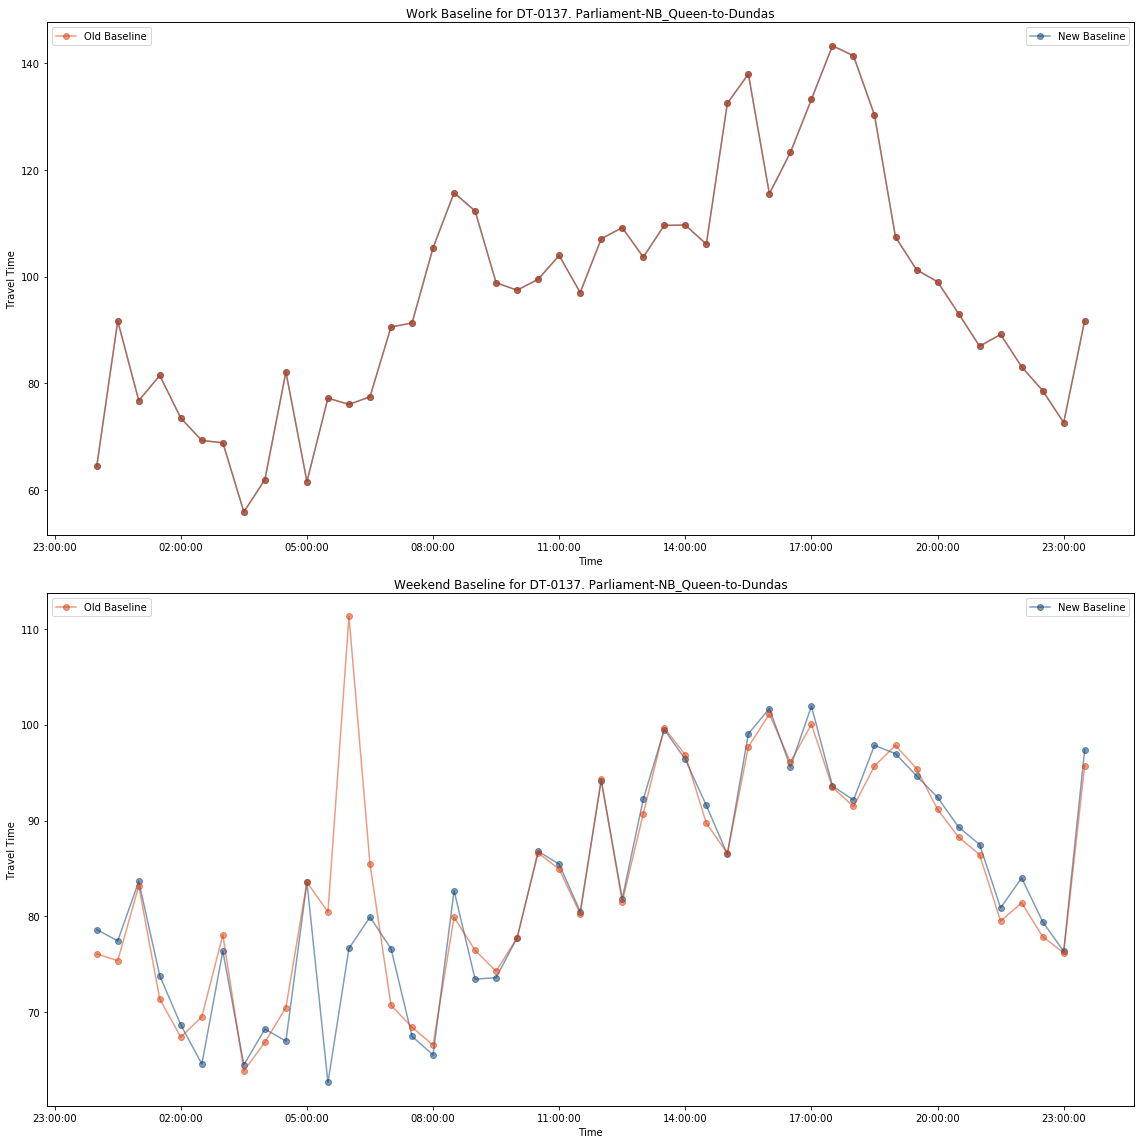

In [36]:
r_name = "DT-0137. Parliament-NB_Queen-to-Dundas"
plot_weeks(r_name, 38)
plot_base(travel_times, r_name)
alternate_baseline(r_name, ['2017-09-24'])

Removing September 16th had a major impact on the weekend baseline in the morning.

In [37]:
sinnister_segments = ["DT-0001.College-EB_Bathurst-to-University",
"DT-0007. Dundas-EB_Bathurst-to-Spadina",
"DT-0024. Queen-EB_University-to-Yonge",
"DT-0026. Queen-EB_Jarvis-to-Parliament",
"DT-0031. Queen-WB_Yonge-to-University",
"DT-0033. Queen-WB_Spadina-to-Bathurst",
"DT-0047. Adelaide-EB_Jarvis-to-Parliament",
"DT-0056. King-EB_Jarvis-to-Parliament",
"DT-0074. Front-EB_Jarvis-to-Parliament",
"DT-0086. Dufferin-SB_Queen-to-King",
"DT-0088. Dufferin-NB_Queen-to-Dundas",
"DT-0094. Bathurst-SB_King-to-Front",
"DT-0099. Bathurst-NB_Queen-to-Dundas",
"DT-0100. Bathurst-NB_Dundas-to-College",
"DT-0108. Spadina-NB_Queen-to-Dundas",
"DT-0109. University-SB_College-to-Dundas",
"DT-0115. University-NB_Front-to-King",
"DT-0128. Jarvis-NB_Front-to-King",
"DT-0129. Jarvis-NB_King-to-Queen",
"DT-0134. Parliament-SB_King-to-Front",
"DT-0137. Parliament-NB_Queen-to-Dundas"]


After looking at single points with highly inflated travel times and longer periods where the baseline was affected by an anomalistic slowdown, it doesn't look like removing either of these types of anomalies has a very controllable impact on the baselines. Since the baseline data is so limited, removing days can change the part of the baseline that wasn't affected by the anomaly as much or even more than the baseline at the time of the anomaly.